# Introduction

Ce notebook correspond au travail fait sur l'approche modélisation additive des données time series pour la prédiction du trafic.

## Contexte

L'idée initiale était de décomposer la modélisation du time series en plusieurs éléments additifs. En notant $y$ la variable time series en question, on a:

$$y=y_{trend}+y_{season}+y_{cycle}+y_{error}$$

Sur cette décomposition, notre stratégie était de prédire chacune des composantes **déterministes** via régression linéaire en utilisant des features time-series inhérentes aux target values. Sur l'erreur restante, notre inuition était qu'on pourrait capturer l'information résiduelle dans l'interaction des target values avec des données venant de sources externes (météo, travaux sur la route, prix du carburant etc.). Un modèle *XGBoost* puis de régression linéaire étaient entraînés sur cette partie résiduelle. Etant donné que les résultats étaient peu satisfants, on a l'a laissé de côté.

## Structure

Dans l'organisation de ce notebook, 2 parties sont attribuées par rue (exemple: - Champs Elysées et Champs Elysées FINAL). La 1ere contient la phase d'exploration (contenant les tests sur XGBoost) et la 2eme le code final pour **générer les prédictions** pour le **livrable 1** du datathon BCG GAMMA.

# Requirements

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from xgboost import XGBRegressor


from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Data Loading

## Testing

In [ ]:
df_baseline = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/BCG_datathon/Data/clean_baseline.csv",delimiter=";")
df_baseline["Date et heure de comptage"]=pd.to_datetime(df_baseline["Date et heure de comptage"], format="%Y-%m-%d %H:%M:%S")

df_baseline.head(5)

Libelle Date et heure de comptage  Débit horaire  \
0  AV_Champs_Elysees       2022-01-01 11:00:00          524.0   
1  AV_Champs_Elysees       2022-01-01 07:00:00          491.0   
2  AV_Champs_Elysees       2022-01-01 19:00:00          997.0   
3  AV_Champs_Elysees       2022-01-01 18:00:00         1096.0   
4  AV_Champs_Elysees       2022-01-01 09:00:00          258.0   

   Taux d'occupation  Etat trafic  Etat arc_Barré  Etat arc_Invalide  
0            8.85667            1               0                  1  
1            7.71611            1               0                  1  
2           46.28889            3               0                  1  
3           46.60222            3               0                  1  
4            3.75445            1               0                  1

In [ ]:
df_chmps = df_baseline[df_baseline["Libelle"]=="AV_Champs_Elysees"]
df_sts = df_baseline[df_baseline["Libelle"]=="Sts_Peres"]
df_cnvtn = df_baseline[df_baseline["Libelle"]=="Convention"]

In [ ]:
df_full = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/BCG_datathon/Data/final_data.csv",delimiter=";")
df_full["Date et heure de comptage"]=pd.to_datetime(df_baseline["Date et heure de comptage"], format="%Y-%m-%d %H:%M:%S")

df_full.drop(columns=["Unnamed: 0"],inplace=True)
df_full.sort_values(by="Date et heure de comptage", inplace=True)

df_full.set_index("Date et heure de comptage", inplace=True)

df_full.head(5)



Libelle  Débit horaire  \
Date et heure de comptage                                     
2021-11-01 04:00:00               Convention          145.0   
2021-11-01 04:00:00                Sts_Peres          163.0   
2021-11-01 04:00:00        AV_Champs_Elysees         1222.0   
2021-11-01 05:00:00                Sts_Peres          125.0   
2021-11-01 05:00:00               Convention          127.0   

                           Taux d'occupation  Etat trafic  Etat arc_Barré  \
Date et heure de comptage                                                   
2021-11-01 04:00:00                  0.91611            1               0   
2021-11-01 04:00:00                  1.94556            1               0   
2021-11-01 04:00:00                 42.87945            3               0   
2021-11-01 05:00:00                  1.67778            1               0   
2021-11-01 05:00:00                  0.76222            1               0   

                           Etat arc_Invalide  Jour férié  \
Date et heure de comptage                                  
2021-11-01 04:00:00                        1           1   
2021-11-01 04:00:00                        1           1   
2021-11-01 04:00:00                        1           1   
2021-11-01 05:00:00                        1           1   
2021-11-01 05:00:00                        1           1   

                           Jour de la semaine_0  Jour de la semaine_1  \
Date et heure de comptage                                               
2021-11-01 04:00:00                           1                     0   
2021-11-01 04:00:00                           1                     0   
2021-11-01 04:00:00                           1                     0   
2021-11-01 05:00:00                           1                     0   
2021-11-01 05:00:00                           1                     0   

                           Jour de la semaine_2  ...  cloudcover  HeatIndexC  \
Date et heure de comptage                        ...                           
2021-11-01 04:00:00                           0  ...          29          10   
2021-11-01 04:00:00                           0  ...          29          10   
2021-11-01 04:00:00                           0  ...          29          10   
2021-11-01 05:00:00                           0  ...          36          10   
2021-11-01 05:00:00                           0  ...          36          10   

                           DewPointC  WindChillC  WindGustKmph  FeelsLikeC  \
Date et heure de comptage                                                    
2021-11-01 04:00:00                7           8            28           8   
2021-11-01 04:00:00                7           8            28           8   
2021-11-01 04:00:00                7           8            28           8   
2021-11-01 05:00:00                7           8            28           8   
2021-11-01 05:00:00                7           8            28           8   

                           is_day  paris_repsire  perturbation_travaux  \
Date et heure de comptage                                                
2021-11-01 04:00:00         False          False                   0.0   
2021-11-01 04:00:00         False          False                   1.0   
2021-11-01 04:00:00         False          False                   0.0   
2021-11-01 05:00:00         False          False                   1.0   
2021-11-01 05:00:00         False          False                   0.0   

                           Prix du carburant  
Date et heure de comptage                     
2021-11-01 04:00:00                   1.5904  
2021-11-01 04:00:00                   1.5904  
2021-11-01 04:00:00                   1.5904  
2021-11-01 05:00:00                   1.5904  
2021-11-01 05:00:00                   1.5904  

[5 rows x 37 columns]

In [ ]:
df_chmps_full = df_full[df_full["Libelle"]=="AV_Champs_Elysees"]
df_sts_full = df_full[df_full["Libelle"]=="Sts_Peres"]
df_cnvtn_full = df_full[df_full["Libelle"]=="Convention"]

## Final dataset (9th of december)

In [ ]:
df_baseline_final = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/BCG_datathon/Data/clean_baseline_final.csv",delimiter=";")
df_baseline_final["Date et heure de comptage"]=pd.to_datetime(df_baseline_final["Date et heure de comptage"], format="%Y-%m-%d %H:%M:%S")

df_baseline_final.head(5)

Libelle Date et heure de comptage  Débit horaire  \
0  AV_Champs_Elysees       2022-01-01 11:00:00          524.0   
1  AV_Champs_Elysees       2022-01-01 07:00:00          491.0   
2  AV_Champs_Elysees       2022-01-01 19:00:00          997.0   
3  AV_Champs_Elysees       2022-01-01 18:00:00         1096.0   
4  AV_Champs_Elysees       2022-01-01 09:00:00          258.0   

   Taux d'occupation  Etat trafic  Etat arc_Barré  Etat arc_Invalide  
0            8.85667            1               0                  1  
1            7.71611            1               0                  1  
2           46.28889            3               0                  1  
3           46.60222            3               0                  1  
4            3.75445            1               0                  1

In [ ]:
df_chmps = df_baseline_final[df_baseline_final["Libelle"]=="AV_Champs_Elysees"]
df_sts = df_baseline_final[df_baseline_final["Libelle"]=="Sts_Peres"]
df_cnvtn = df_baseline_final[df_baseline_final["Libelle"]=="Convention"]

# Util functions

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
def rmse(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))

# Champs Elysées

In [ ]:
df_chmps_base = df_chmps.drop(columns=["Libelle","Etat trafic","Etat arc_Barré", "Etat arc_Invalide"])
df_chmps_base.sort_values(by="Date et heure de comptage", inplace=True)
df_chmps_base.set_index("Date et heure de comptage",inplace=True)
df_chmps_base

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00               1222.0           42.87945
2021-11-01 05:00:00               1033.0           44.35278
2021-11-01 06:00:00                824.0           20.16222
2021-11-01 07:00:00                710.0           12.20000
2021-11-01 08:00:00                947.0           40.57222
...                                  ...                ...
2022-12-03 20:00:00               1178.0           35.10778
2022-12-03 21:00:00               1107.0           46.05833
2022-12-03 22:00:00               1256.0           33.02056
2022-12-03 23:00:00               1189.0           31.78667
2022-12-04 00:00:00               1096.0           26.32444

[9186 rows x 2 columns]

In [ ]:
df_chmps_base_freq = df_chmps_base.asfreq('H', method= 'ffill')
df_chmps_base_freq

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00               1222.0           42.87945
2021-11-01 05:00:00               1033.0           44.35278
2021-11-01 06:00:00                824.0           20.16222
2021-11-01 07:00:00                710.0           12.20000
2021-11-01 08:00:00                947.0           40.57222
...                                  ...                ...
2022-12-03 20:00:00               1178.0           35.10778
2022-12-03 21:00:00               1107.0           46.05833
2022-12-03 22:00:00               1256.0           33.02056
2022-12-03 23:00:00               1189.0           31.78667
2022-12-04 00:00:00               1096.0           26.32444

[9549 rows x 2 columns]

In [ ]:
df_chmps_base_freq - df_chmps_base

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00                  0.0                0.0
2021-11-01 05:00:00                  0.0                0.0
2021-11-01 06:00:00                  0.0                0.0
2021-11-01 07:00:00                  0.0                0.0
2021-11-01 08:00:00                  0.0                0.0
...                                  ...                ...
2022-12-03 20:00:00                  0.0                0.0
2022-12-03 21:00:00                  0.0                0.0
2022-12-03 22:00:00                  0.0                0.0
2022-12-03 23:00:00                  0.0                0.0
2022-12-04 00:00:00                  0.0                0.0

[9549 rows x 2 columns]

### Trend

In [ ]:
y = df_chmps_base.copy()

# Create trend features
dp = DeterministicProcess(
    index = y.index,
    constant=True,
    order=1,
    drop=True
)
X = dp.in_sample()

In [ ]:
X_train,X_test,y_train,y_test = timeseries_train_test_split(X, y, test_size=0.1)

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


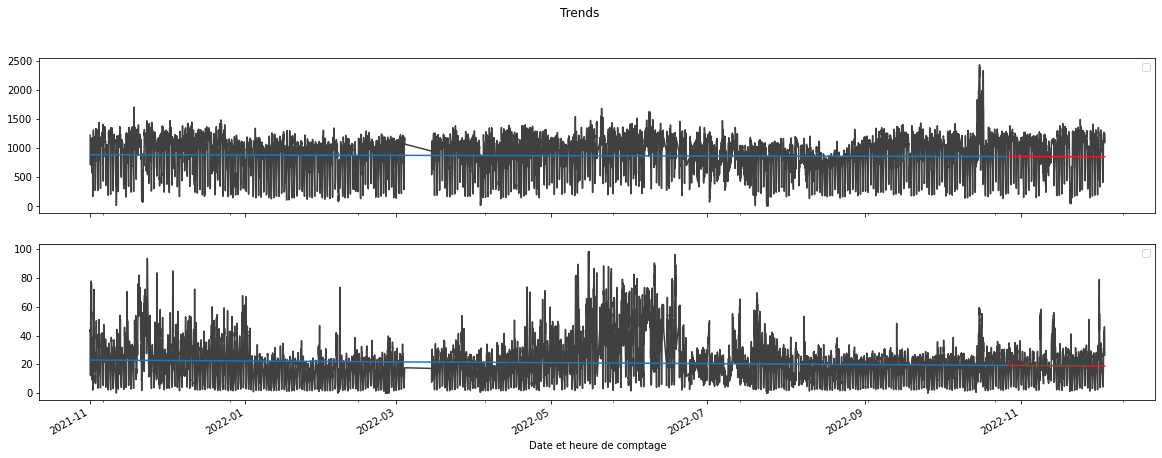

In [ ]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X_train,y_train)

y_trend_fit = pd.DataFrame(
    linear_model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_trend_pred = pd.DataFrame(
    linear_model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_trend_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_trend_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


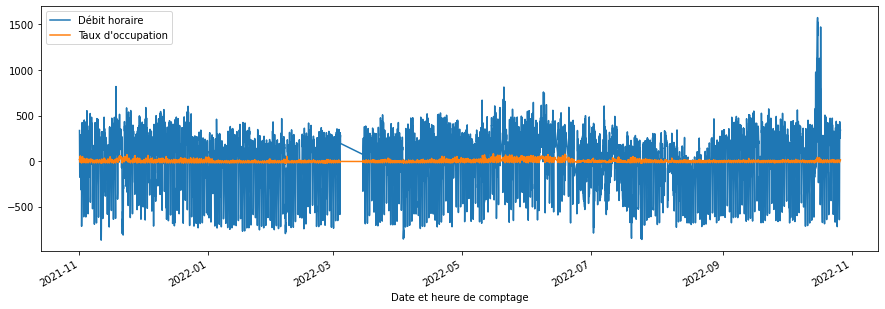

In [ ]:
# We remove the trend

y_detrended = y_train - y_trend_fit
y_detrended.plot(figsize=(15,5))

In [ ]:
y_detrended_test = y_test - y_trend_pred


### Seasonality

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


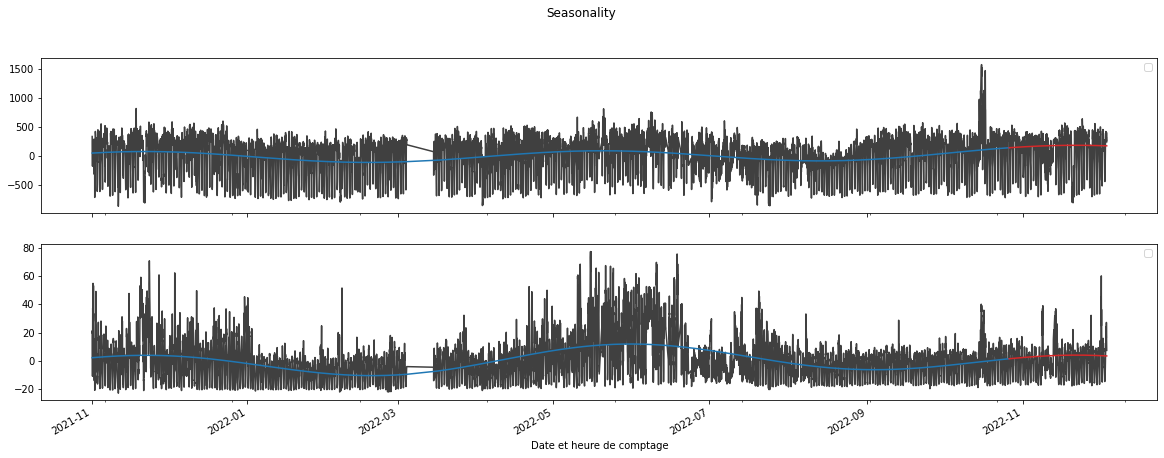

In [ ]:


# Let's now look at seasonality

fourier = CalendarFourier(freq="A", order=2)  # 10 sin/cos pairs for "A"nnual seasonality

dp_season = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season = dp_season.in_sample() 

X_train_season,X_test_season,y_train,y_test = timeseries_train_test_split(X_season, y, test_size=0.1)

linear_model_season = LinearRegression(fit_intercept=False)
linear_model_season.fit(X_train_season,y_detrended)

y_season_fit = pd.DataFrame(
    linear_model_season.predict(X_train_season),
    index=y_train.index,
    columns=y_train.columns,
)

y_season_pred = pd.DataFrame(
    linear_model_season.predict(X_test_season),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_detrended.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_detrended_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_season_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_season_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Seasonality")

Let's try weekly seasonality

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


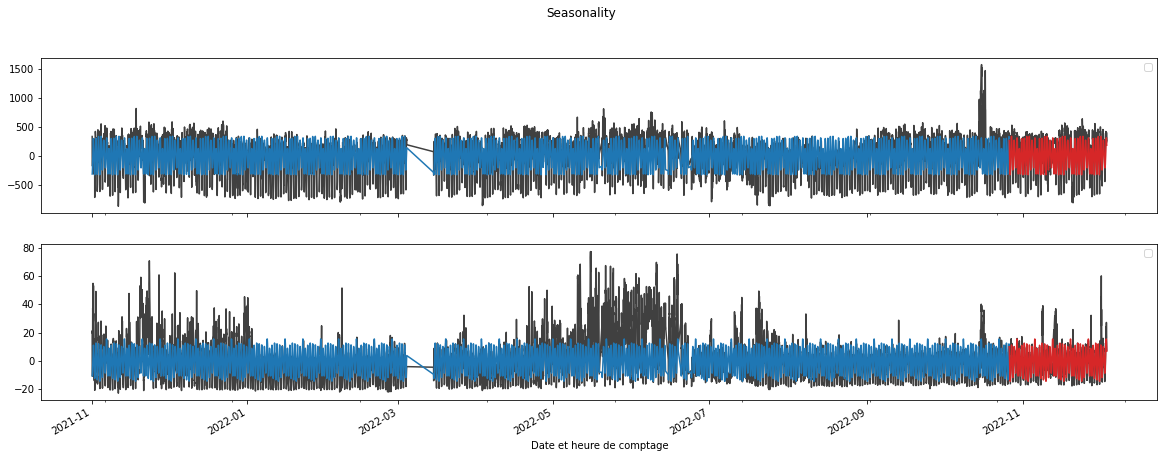

In [ ]:


# Let's now look at seasonality

fourier = CalendarFourier(freq="W", order=10)  # 10 sin/cos pairs for "W"eekly seasonality

dp_season = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season = dp_season.in_sample() 

X_train_season,X_test_season,y_train,y_test = timeseries_train_test_split(X_season, y, test_size=0.1)

linear_model_season = LinearRegression(fit_intercept=False)
linear_model_season.fit(X_train_season,y_detrended)

y_season_fit = pd.DataFrame(
    linear_model_season.predict(X_train_season),
    index=y_train.index,
    columns=y_train.columns,
)

y_season_pred = pd.DataFrame(
    linear_model_season.predict(X_test_season),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_detrended.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_detrended_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_season_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_season_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Seasonality")

#### Testing different fourier order values

In [ ]:
def testing_best_fourier_order(freq_type, order):

  fourier = CalendarFourier(freq=freq_type, order=order)  # 10 sin/cos pairs for "W"eekly seasonality

  dp_season = DeterministicProcess(
      index=y.index,
      constant=True,               # dummy feature for bias (y-intercept)
      order=1,                     # trend (order 1 means linear)
      seasonal=False,               # weekly seasonality (indicators)
      additional_terms=[fourier],  # annual seasonality (fourier)
      drop=True,                   # drop terms to avoid collinearity
  )

  X_season = dp_season.in_sample() 

  X_train_season,X_test_season,y_train,y_test = timeseries_train_test_split(X_season, y, test_size=0.1)

  linear_model_season = LinearRegression(fit_intercept=False)
  linear_model_season.fit(X_train_season,y_detrended)

  y_season_fit = pd.DataFrame(
      linear_model_season.predict(X_train_season),
      index=y_train.index,
      columns=y_train.columns,
  )

  y_season_pred = pd.DataFrame(
      linear_model_season.predict(X_test_season),
      index=y_test.index,
      columns=y_test.columns,
  )
  print(f"RMSE on test set is for a Fourier order of {order} is: ", rmse(y_detrended_test,y_season_pred))
  print(f"RMSE on train set is for a Fourier order of {order} is: ", rmse(y_detrended,y_season_fit))

In [ ]:
for i in range(1,30):
  testing_best_fourier_order(freq_type="W",order=i)

RMSE on test set is for a Fourier order of 1 is:  237.7598498327926
RMSE on train set is for a Fourier order of 1 is:  227.69188544131111
RMSE on test set is for a Fourier order of 2 is:  236.90298477904443
RMSE on train set is for a Fourier order of 2 is:  227.3268313168533
RMSE on test set is for a Fourier order of 3 is:  236.48557272287778
RMSE on train set is for a Fourier order of 3 is:  227.172750881506
RMSE on test set is for a Fourier order of 4 is:  235.76582063623673
RMSE on train set is for a Fourier order of 4 is:  226.7570612496304
RMSE on test set is for a Fourier order of 5 is:  232.64225543539078
RMSE on train set is for a Fourier order of 5 is:  225.586831618481
RMSE on test set is for a Fourier order of 6 is:  227.11737301380987
RMSE on train set is for a Fourier order of 6 is:  220.55868407880425
RMSE on test set is for a Fourier order of 7 is:  183.88852058542165
RMSE on train set is for a Fourier order of 7 is:  179.63089058067135
RMSE on test set is for a Fourier 

In [ ]:
for i in range(1,30):
  testing_best_fourier_order(freq_type="M",order=i)

RMSE on test set is for a Fourier order of 1 is:  240.07903963719585
RMSE on train set is for a Fourier order of 1 is:  228.38617393985677
RMSE on test set is for a Fourier order of 2 is:  240.07370747097085
RMSE on train set is for a Fourier order of 2 is:  228.34972425075344
RMSE on test set is for a Fourier order of 3 is:  239.9943184750296
RMSE on train set is for a Fourier order of 3 is:  228.31947501839107
RMSE on test set is for a Fourier order of 4 is:  240.70170616831763
RMSE on train set is for a Fourier order of 4 is:  228.19143597289923
RMSE on test set is for a Fourier order of 5 is:  240.82403800557282
RMSE on train set is for a Fourier order of 5 is:  228.1508557343796
RMSE on test set is for a Fourier order of 6 is:  241.26626770967238
RMSE on train set is for a Fourier order of 6 is:  228.1236604800561
RMSE on test set is for a Fourier order of 7 is:  241.82882976692943
RMSE on train set is for a Fourier order of 7 is:  228.05336276469353
RMSE on test set is for a Four

In [ ]:
for i in range(1,30):
  testing_best_fourier_order(freq_type="A",order=i)

RMSE on test set is for a Fourier order of 1 is:  244.19701617764972
RMSE on train set is for a Fourier order of 1 is:  228.1794959159707
RMSE on test set is for a Fourier order of 2 is:  253.42470045805496
RMSE on train set is for a Fourier order of 2 is:  223.22814148416998
RMSE on test set is for a Fourier order of 3 is:  246.554088970786
RMSE on train set is for a Fourier order of 3 is:  222.97110055431295
RMSE on test set is for a Fourier order of 4 is:  254.33764090675072
RMSE on train set is for a Fourier order of 4 is:  222.0091689813903
RMSE on test set is for a Fourier order of 5 is:  249.8142596079947
RMSE on train set is for a Fourier order of 5 is:  221.93301051048175
RMSE on test set is for a Fourier order of 6 is:  253.32207925502126
RMSE on train set is for a Fourier order of 6 is:  221.92511178419835
RMSE on test set is for a Fourier order of 7 is:  256.2785169796183
RMSE on train set is for a Fourier order of 7 is:  221.86536345025885
RMSE on test set is for a Fourier

#### Choosing best value from "grid search"

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


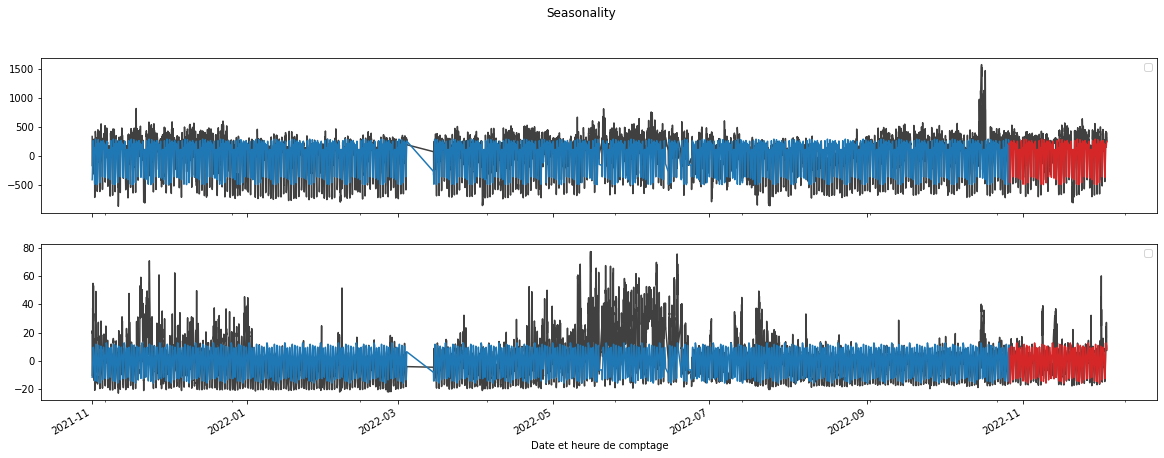

In [ ]:

# Let's now look at seasonality

fourier = CalendarFourier(freq="W", order=15)  

dp_season = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season = dp_season.in_sample() 

X_train_season,X_test_season,y_train,y_test = timeseries_train_test_split(X_season, y, test_size=0.1)

linear_model_season = LinearRegression(fit_intercept=False)
linear_model_season.fit(X_train_season,y_detrended)

y_season_fit = pd.DataFrame(
    linear_model_season.predict(X_train_season),
    index=y_train.index,
    columns=y_train.columns,
)

y_season_pred = pd.DataFrame(
    linear_model_season.predict(X_test_season),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_detrended.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_detrended_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_season_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_season_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Seasonality")

#### De-seasoned result

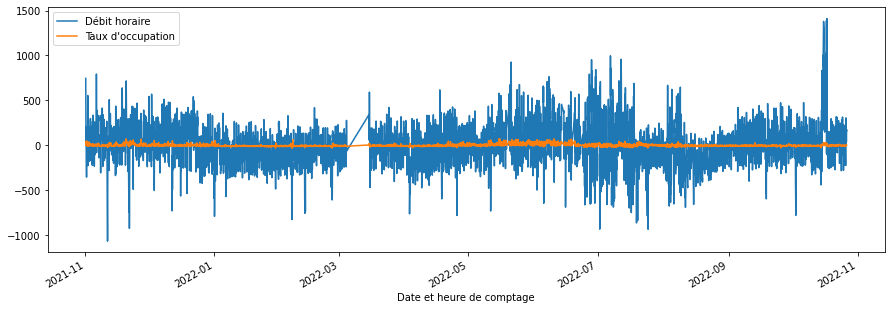

In [ ]:
y_deseasoned = y_detrended - y_season_fit
y_deseasoned.plot(figsize=(15,5))

In [ ]:
y_deseasoned_test = y_detrended_test - y_season_pred


### Cycles

In [ ]:
y_deseasoned_total = pd.concat([y_deseasoned,y_deseasoned_test])
y_deseasoned_total

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00           745.281383          31.438578
2021-11-01 05:00:00           532.318229          32.778161
2021-11-01 06:00:00           250.534409           7.326954
2021-11-01 07:00:00            25.032663          -2.919976
2021-11-01 08:00:00           130.033711          22.400059
...                                  ...                ...
2022-12-03 20:00:00           159.216789           4.590502
2022-12-03 21:00:00            59.061699          15.895944
2022-12-03 22:00:00           174.449940           3.337820
2022-12-03 23:00:00            83.671254           2.957293
2022-12-04 00:00:00            -8.889413          -1.022005

[9186 rows x 2 columns]

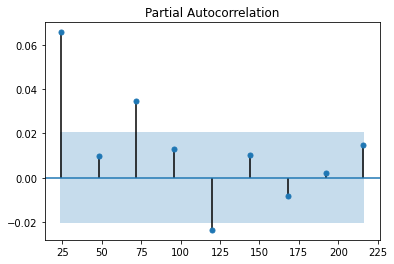

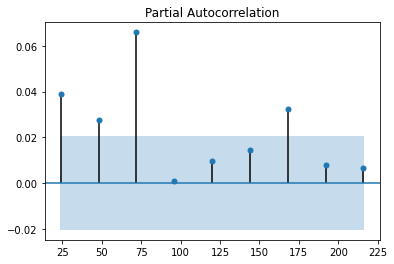

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_pacf(y_deseasoned_total["Débit horaire"],lags=[24*i for i in range(1,10)])
_ = plot_pacf(y_deseasoned_total["Taux d'occupation"],lags=[24*i for i in range(1,10)])

We see that among the lags we can use (needs to be at least > 5 days), 5 days for debit and 7 days for taux works the best.

In [ ]:
 y_deseasoned_total["Débit horaire"]

Date et heure de comptage
2021-11-01 04:00:00    745.281383
2021-11-01 05:00:00    532.318229
2021-11-01 06:00:00    250.534409
2021-11-01 07:00:00     25.032663
2021-11-01 08:00:00    130.033711
                          ...    
2022-12-03 20:00:00    159.216789
2022-12-03 21:00:00     59.061699
2022-12-03 22:00:00    174.449940
2022-12-03 23:00:00     83.671254
2022-12-04 00:00:00     -8.889413
Name: Débit horaire, Length: 9186, dtype: float64

#### Choosing best lag features for debit

In [ ]:
def choose_best_lag(lag):
  X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag)],axis=1)
  X_lag_debit  = X_lag_debit.fillna(0.0)

  y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

  linear_model_cycle = LinearRegression(fit_intercept=False)

  X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

  linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

  y_cycle_debit_fit = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_debit_train),
      index = y_cycle_debit_train.index,
      columns = ["Débit horaire"],
  )

  y_cycle_debit_pred = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_debit_test),
      index = y_cycle_debit_test.index,
      columns = ["Débit horaire"],
  )

  print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test,y_cycle_debit_pred))
  print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

In [ ]:
for lag in range(5,14):
  choose_best_lag(lag)

RMSE on test set is for a lag of 5 is:  227.97127036622442
RMSE on train set is for a lag of 5 is:  217.36584025597497
RMSE on test set is for a lag of 6 is:  230.53506726989505
RMSE on train set is for a lag of 6 is:  214.37784916680806
RMSE on test set is for a lag of 7 is:  233.29787013842184
RMSE on train set is for a lag of 7 is:  212.1552376467161
RMSE on test set is for a lag of 8 is:  224.73527094910202
RMSE on train set is for a lag of 8 is:  215.6352800315529
RMSE on test set is for a lag of 9 is:  222.97053959192135
RMSE on train set is for a lag of 9 is:  218.870236791243
RMSE on test set is for a lag of 10 is:  223.54963658740556
RMSE on train set is for a lag of 10 is:  217.32717671014822
RMSE on test set is for a lag of 11 is:  223.58106064704734
RMSE on train set is for a lag of 11 is:  218.557564198158
RMSE on test set is for a lag of 12 is:  232.22112446297265
RMSE on train set is for a lag of 12 is:  219.31490337228388
RMSE on test set is for a lag of 13 is:  231.714

In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(8,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  221.16010459690824
RMSE on train set is for a lag of 13 is:  212.09236201614883


In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  227.32915780782406
RMSE on train set is for a lag of 13 is:  204.6850789422643


In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(5,8)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  233.38149238069624
RMSE on train set is for a lag of 13 is:  207.519366084359


In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(7,9)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  230.70433325685232
RMSE on train set is for a lag of 13 is:  209.6140884533485


#### Applying best lag value for debit

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


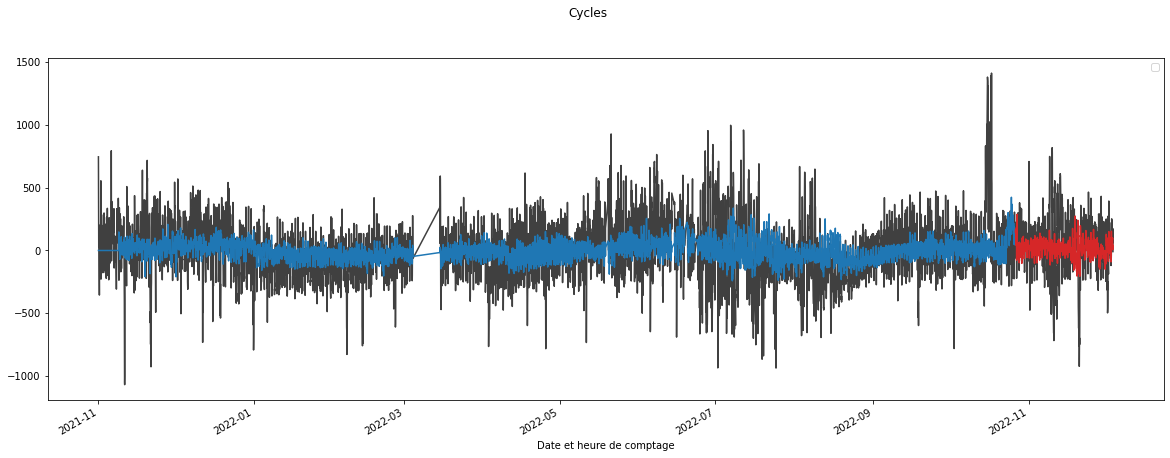

In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(8,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

axs = y_cycle_debit_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_debit_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


#### Choosing best lag features for taux

In [ ]:
def choose_best_lag(lag):
  X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag)],axis=1)
  X_lag_taux  = X_lag_taux.fillna(0.0)

  y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

  linear_model_cycle = LinearRegression(fit_intercept=False)

  X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

  linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

  y_cycle_taux_fit = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_taux_train),
      index = y_cycle_taux_train.index,
      columns = ["Taux d'occupation"],
  )

  y_cycle_taux_pred = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_taux_test),
      index = y_cycle_taux_test.index,
      columns = ["Taux d'occupation"],
  )
  print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
  print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

In [ ]:
for i in range(5,14):
  choose_best_lag(i)

RMSE on test set is for a lag of 5 is:  8.422278906080688
RMSE on train set is for a lag of 5 is:  11.616303334037202
RMSE on test set is for a lag of 6 is:  8.623362150504681
RMSE on train set is for a lag of 6 is:  11.640145843535311
RMSE on test set is for a lag of 7 is:  8.749361218346998
RMSE on train set is for a lag of 7 is:  11.595596904758452
RMSE on test set is for a lag of 8 is:  8.588871022738207
RMSE on train set is for a lag of 8 is:  11.634209596157708
RMSE on test set is for a lag of 9 is:  8.536851415254441
RMSE on train set is for a lag of 9 is:  11.762014118276227
RMSE on test set is for a lag of 10 is:  8.589849939121457
RMSE on train set is for a lag of 10 is:  11.781505403839075
RMSE on test set is for a lag of 11 is:  8.714579045613055
RMSE on train set is for a lag of 11 is:  11.932698595849878
RMSE on test set is for a lag of 12 is:  8.80478756357557
RMSE on train set is for a lag of 12 is:  12.029977791927395
RMSE on test set is for a lag of 13 is:  8.73854722

In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(8,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  8.461698933398742
RMSE on train set is for a lag of 13 is:  11.271994326381375


In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  8.37522036057141
RMSE on train set is for a lag of 13 is:  10.868067083283885


In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,8)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  8.47416791516135
RMSE on train set is for a lag of 13 is:  11.109659105386875


In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,9)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  8.42774361989612
RMSE on train set is for a lag of 13 is:  10.979162924231481


#### Applying best lag value for taux

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


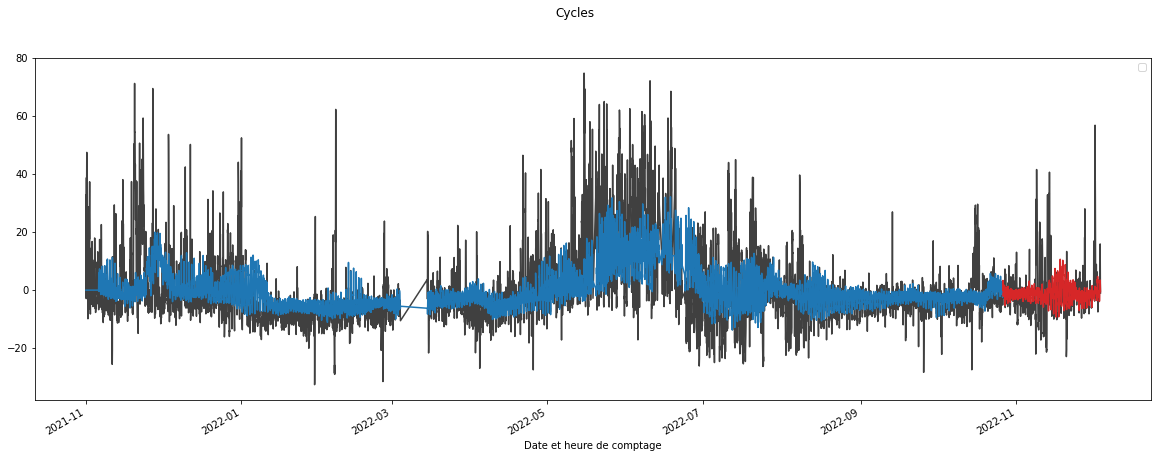

In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)

axs = y_cycle_taux_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_taux_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


In [ ]:
y_deseasoned_debit = y_deseasoned.drop(columns=["Taux d'occupation"])
y_deseasoned_taux = y_deseasoned.drop(columns=["Débit horaire"])

y_deseasoned_debit_test = y_deseasoned_test.drop(columns=["Taux d'occupation"])
y_deseasoned_taux_test = y_deseasoned_test.drop(columns=["Débit horaire"])

In [ ]:
y_residual_debit_train = y_deseasoned_debit - y_cycle_debit_fit
y_residual_debit_test = y_deseasoned_debit_test - y_cycle_debit_pred

y_residual_taux_train = y_deseasoned_taux - y_cycle_taux_fit
y_residual_taux_test = y_deseasoned_taux_test - y_cycle_taux_pred

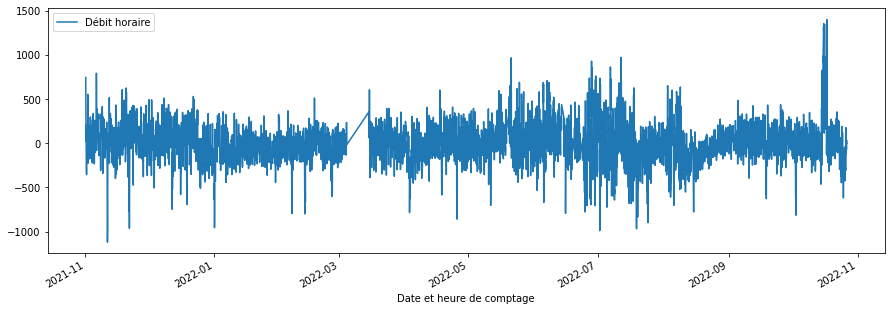

In [ ]:
y_residual_debit_train.plot(figsize=(15,5))

### Trend + season + cycles

In [ ]:
y_cycle_pred = pd.concat([y_cycle_taux_pred,y_cycle_debit_pred],axis=1)
y_cycle_pred

Taux d'occupation  Débit horaire
Date et heure de comptage                                  
2022-10-26 18:00:00                 0.032714     146.996571
2022-10-26 19:00:00                 3.337424     154.402189
2022-10-26 20:00:00                 3.053698     168.310846
2022-10-26 21:00:00                 0.199558      92.619994
2022-10-26 22:00:00                -2.132391      62.421291
...                                      ...            ...
2022-12-03 20:00:00                 2.641046     100.600116
2022-12-03 21:00:00                 3.467241      63.738864
2022-12-03 22:00:00                 0.859184       6.138634
2022-12-03 23:00:00                 0.839621      42.009055
2022-12-04 00:00:00                -0.496622      27.292417

[919 rows x 2 columns]

In [ ]:
y_cycle_fit = pd.concat([y_cycle_taux_fit,y_cycle_debit_fit],axis=1)
y_cycle_fit

Taux d'occupation  Débit horaire
Date et heure de comptage                                  
2021-11-01 04:00:00                 0.000000       0.000000
2021-11-01 05:00:00                 0.000000       0.000000
2021-11-01 06:00:00                 0.000000       0.000000
2021-11-01 07:00:00                 0.000000       0.000000
2021-11-01 08:00:00                 0.000000       0.000000
...                                      ...            ...
2022-10-26 13:00:00                -1.004325      44.441306
2022-10-26 14:00:00                -1.829152      99.002551
2022-10-26 15:00:00                -2.487417     140.073483
2022-10-26 16:00:00                -1.767860     140.026395
2022-10-26 17:00:00                -0.194302     158.952617

[8267 rows x 2 columns]

In [ ]:
y_pred_deterministic = y_trend_pred + y_season_pred + y_cycle_pred 
y_pred_deterministic

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2022-10-26 18:00:00          1204.678861          28.117895
2022-10-26 19:00:00          1231.334141          29.806040
2022-10-26 20:00:00          1243.905703          27.502186
2022-10-26 21:00:00          1131.723850          22.219981
2022-10-26 22:00:00          1023.587933          17.071271
...                                  ...                ...
2022-12-03 20:00:00          1119.383327          33.158324
2022-12-03 21:00:00          1111.677165          33.629627
2022-12-03 22:00:00          1087.688694          30.541924
2022-12-03 23:00:00          1147.337801          29.668998
2022-12-04 00:00:00          1132.181830          26.849823

[919 rows x 2 columns]

In [ ]:
y_fit_deterministic = y_trend_fit + y_season_fit + y_cycle_fit
y_fit_deterministic

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00           476.718617          11.440872
2021-11-01 05:00:00           500.681771          11.574619
2021-11-01 06:00:00           573.465591          12.835266
2021-11-01 07:00:00           684.967337          15.119976
2021-11-01 08:00:00           816.966289          18.172161
...                                  ...                ...
2022-10-26 13:00:00          1152.941276          27.579878
2022-10-26 14:00:00          1169.223506          27.970565
2022-10-26 15:00:00          1179.089207          27.761843
2022-10-26 16:00:00          1166.886196          28.273421
2022-10-26 17:00:00          1194.754657          29.096499

[8267 rows x 2 columns]

In [ ]:
X = df_chmps_base
y = df_chmps_base

_,_,y_train,y_test = timeseries_train_test_split(X,y,test_size=0.1)

In [ ]:
y_train

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00               1222.0           42.87945
2021-11-01 05:00:00               1033.0           44.35278
2021-11-01 06:00:00                824.0           20.16222
2021-11-01 07:00:00                710.0           12.20000
2021-11-01 08:00:00                947.0           40.57222
...                                  ...                ...
2022-10-26 13:00:00               1164.0           25.76889
2022-10-26 14:00:00               1109.0           30.08334
2022-10-26 15:00:00               1108.0           25.11056
2022-10-26 16:00:00               1203.0           25.23834
2022-10-26 17:00:00               1196.0           30.32833

[8267 rows x 2 columns]

In [ ]:
y_test

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2022-10-26 18:00:00               1224.0           26.21167
2022-10-26 19:00:00               1252.0           24.11722
2022-10-26 20:00:00               1222.0           22.96056
2022-10-26 21:00:00               1170.0           21.08667
2022-10-26 22:00:00                901.0           17.83889
...                                  ...                ...
2022-12-03 20:00:00               1178.0           35.10778
2022-12-03 21:00:00               1107.0           46.05833
2022-12-03 22:00:00               1256.0           33.02056
2022-12-03 23:00:00               1189.0           31.78667
2022-12-04 00:00:00               1096.0           26.32444

[919 rows x 2 columns]

#### On test set

In [ ]:
rmse(y_test,y_pred_deterministic)

156.4959043895455

In [ ]:
rmse(y_test["Taux d'occupation"],y_pred_deterministic["Taux d'occupation"])

8.37522036057141

In [ ]:
rmse(y_test["Débit horaire"],y_pred_deterministic["Débit horaire"])

221.16010459690824

#### On train set

In [ ]:
rmse(y_train["Débit horaire"],y_fit_deterministic["Débit horaire"])

212.0923620161488

In [ ]:
rmse(y_train["Taux d'occupation"],y_fit_deterministic["Taux d'occupation"])

10.868067083283883

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


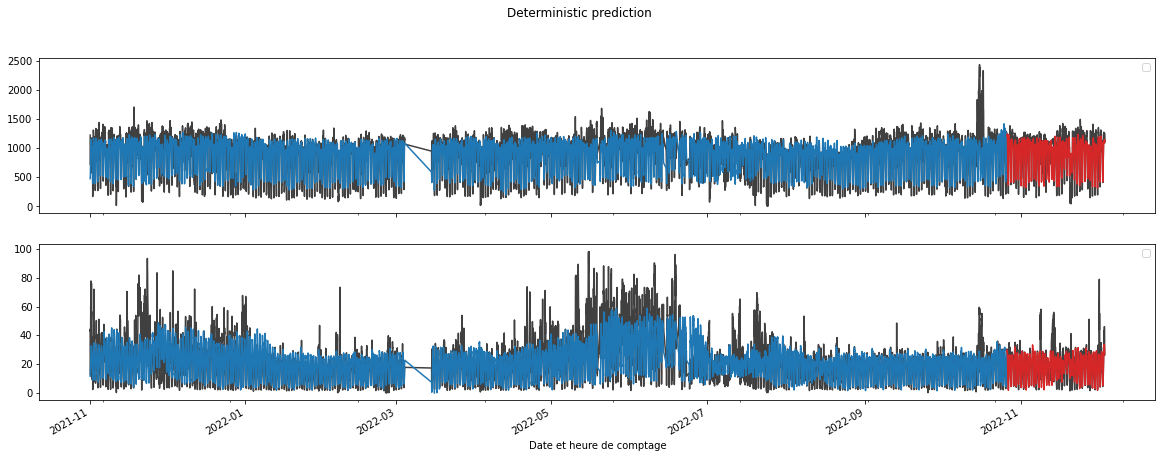

In [ ]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit_deterministic.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred_deterministic.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Deterministic prediction")


### Dealing with Residual

In [ ]:
y_residual_train = y_train - y_fit_deterministic
y_residual_test = y_test - y_pred_deterministic

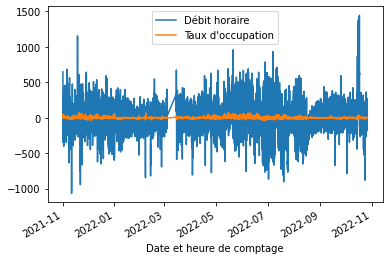

In [ ]:
y_residual_train.plot()

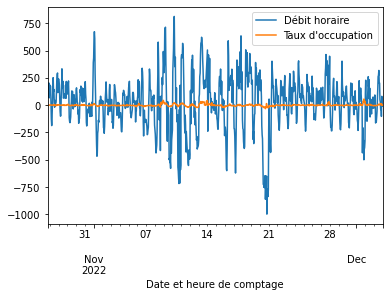

In [ ]:
y_residual_test.plot()

In [ ]:
df_chmps_full.columns

Index(['Libelle', 'Débit horaire', 'Taux d'occupation', 'Etat trafic',
       'Etat arc_Barré', 'Etat arc_Invalide', 'Jour férié',
       'Jour de la semaine_0', 'Jour de la semaine_1', 'Jour de la semaine_2',
       'Jour de la semaine_3', 'Jour de la semaine_4', 'Jour de la semaine_5',
       'Jour de la semaine_6', 'maxtempC', 'mintempC', 'avgtempC',
       'totalSnow_cm', 'uvIndex', 'tempC', 'windspeedKmph', 'winddirDegree',
       'weatherCode', 'precipMM', 'humidity', 'visibility', 'pressure',
       'cloudcover', 'HeatIndexC', 'DewPointC', 'WindChillC', 'WindGustKmph',
       'FeelsLikeC', 'is_day', 'paris_repsire', 'perturbation_travaux',
       'Prix du carburant'],
      dtype='object')

In [ ]:
unused_columns_for_debit = [
    "Libelle",
    "Débit horaire",
    "Taux d'occupation",
    "Etat trafic",
    "Etat arc_Barré",
    "Etat arc_Invalide",
    "Prix du carburant",
    'Jour de la semaine_0', 
    'Jour de la semaine_1', 
    'Jour de la semaine_2',
    'Jour de la semaine_3', 
    'Jour de la semaine_4', 
    'Jour de la semaine_5',
    'Jour de la semaine_6',
    ]

unused_weather = [
    "maxtempC",
    "mintempC",
    "avgtempC",
    "visibility",
    "pressure",
    "HeatIndexC",
    "DewPointC",
    "WindChillC",
    "WindGustKmph",   
    "FeelsLikeC",
    "weatherCode",
    "winddirDegree"
]

In [ ]:
X_external = df_chmps_full.drop(columns=unused_columns_for_debit+unused_weather)
X_external["Jour férié"]=X_external["Jour férié"].astype(bool)
X_external["perturbation_travaux"]=X_external["perturbation_travaux"].astype(bool)


X_external

Jour férié  totalSnow_cm  uvIndex  tempC  \
Date et heure de comptage                                             
2021-11-01 04:00:00              True           0.0        1     10   
2021-11-01 05:00:00              True           0.0        1     10   
2021-11-01 06:00:00              True           0.0        4     11   
2021-11-01 07:00:00              True           0.0        4     10   
2021-11-01 08:00:00              True           0.0        4     10   
...                               ...           ...      ...    ...   
2022-12-03 20:00:00             False           0.0        1      3   
2022-12-03 21:00:00             False           0.0        1      3   
2022-12-03 22:00:00             False           0.0        1      3   
2022-12-03 23:00:00             False           0.0        1      2   
2022-12-04 00:00:00             False           0.0        1      2   

                           windspeedKmph  precipMM  humidity  cloudcover  \
Date et heure de comptage                                                  
2021-11-01 04:00:00                   18       0.0        79          29   
2021-11-01 05:00:00                   19       0.0        78          36   
2021-11-01 06:00:00                   19       0.0        76          43   
2021-11-01 07:00:00                   18       0.0        76          32   
2021-11-01 08:00:00                   17       0.0        76          21   
...                                  ...       ...       ...         ...   
2022-12-03 20:00:00                   12       0.0        78         100   
2022-12-03 21:00:00                   12       0.0        78         100   
2022-12-03 22:00:00                   11       0.0        79          71   
2022-12-03 23:00:00                   10       0.0        80          42   
2022-12-04 00:00:00                    9       0.0        81          12   

                           is_day  paris_repsire  perturbation_travaux  
Date et heure de comptage                                               
2021-11-01 04:00:00         False          False                 False  
2021-11-01 05:00:00         False          False                 False  
2021-11-01 06:00:00         False          False                 False  
2021-11-01 07:00:00         False          False                 False  
2021-11-01 08:00:00          True          False                 False  
...                           ...            ...                   ...  
2022-12-03 20:00:00         False          False                  True  
2022-12-03 21:00:00         False          False                  True  
2022-12-03 22:00:00         False          False                  True  
2022-12-03 23:00:00         False          False                  True  
2022-12-04 00:00:00         False          False                  True  

[9186 rows x 11 columns]

In [ ]:
X_external_train,X_external_test,_,_ = timeseries_train_test_split(X_external,y,test_size=0.1)

In [ ]:
y_residual_train_debit = y_residual_train.drop(columns=["Taux d'occupation"])
y_residual_test_debit = y_residual_test.drop(columns=["Taux d'occupation"])

In [ ]:
y_residual_train_taux = y_residual_train.drop(columns=["Débit horaire"])
y_residual_test_taux = y_residual_test.drop(columns=["Débit horaire"])

#### Initial test: no standardization, no hyperparameter tuning

In [ ]:
# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_external_train, y_residual_train_debit)

[14:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
# Add the predicted residuals onto the predicted deterministic 
y_fit_boosted = xgb.predict(X_external_train) + y_fit_deterministic["Débit horaire"]
y_pred_boosted = xgb.predict(X_external_test) + y_pred_deterministic["Débit horaire"]

In [ ]:
rmse(y_test["Débit horaire"],y_pred_boosted)

266.893157007374

#### Standardization

In [ ]:
X_external_train.columns

Index(['Jour férié', 'totalSnow_cm', 'uvIndex', 'tempC', 'windspeedKmph',
       'precipMM', 'humidity', 'cloudcover', 'is_day', 'paris_repsire',
       'perturbation_travaux'],
      dtype='object')

In [ ]:
numerical_features = [
    "totalSnow_cm",
    "uvIndex",	
    "tempC",	
    "windspeedKmph",	
    "precipMM",	
    "humidity",
    "cloudcover"
]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(X_external_train[numerical_features])
X_external_train[numerical_features] = scaler.transform(X_external_train[numerical_features])
X_external_test[numerical_features] = scaler.transform(X_external_test[numerical_features])

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_external_train, y_residual_train_debit)

[23:09:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
# Add the predicted residuals onto the predicted deterministic 
y_fit_boosted = xgb.predict(X_external_train) + y_fit_deterministic["Débit horaire"]
y_pred_boosted = xgb.predict(X_external_test) + y_pred_deterministic["Débit horaire"]

In [ ]:
rmse(y_test["Débit horaire"],y_pred_boosted)

251.48011799081593

In [ ]:
rmse(y_train["Débit horaire"],y_fit_boosted)

215.4308119737366

#### Initial gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid = {
    'max_depth': [6, 10, 15, 20],
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.3, 0.01, 0.05]
}

grid_search = GridSearchCV(XGBRegressor(),param_grid=pgrid,cv=5,verbose=11)
grid_search.fit(X_external_train, y_residual_train_debit)



Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START learning_rate=0.3, max_depth=6, n_estimators=100...........
[23:17:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5; 1/36] END learning_rate=0.3, max_depth=6, n_estimators=100;, score=-0.233 total time=   0.6s
[CV 2/5; 1/36] START learning_rate=0.3, max_depth=6, n_estimators=100...........
[23:17:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5; 1/36] END learning_rate=0.3, max_depth=6, n_estimators=100;, score=-0.414 total time=   0.7s
[CV 3/5; 1/36] START learning_rate=0.3, max_depth=6, n_estimators=100...........
[23:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5; 1/36] END learning_rate=0.3, max_depth=6, n_estimators=100;, score=-0.232 total time=   0.9s
[CV 4/5;

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.3, 0.01, 0.05],
                         'max_depth': [6, 10, 15, 20],
                         'n_estimators': [100, 200, 500]},
             verbose=11)

In [ ]:
print('n_estimators = ' + str(grid_search.best_estimator_.n_estimators))
print('max_depth = ' + str(grid_search.best_estimator_.max_depth))
print('learning_rate = ' + str(grid_search.best_estimator_.learning_rate))

n_estimators = 100
max_depth = 6
learning_rate = 0.01


In [ ]:
# Train XGBoost on the residuals
xgb = XGBRegressor(n_estimators=100,max_depth=6,learning_rate=0.01)
xgb.fit(X_external_train, y_residual_train_debit)

[23:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.01, max_depth=6)

In [ ]:
# Add the predicted residuals onto the predicted deterministic 
y_fit_boosted = xgb.predict(X_external_train) + y_fit_deterministic["Débit horaire"]
y_pred_boosted = xgb.predict(X_external_test) + y_pred_deterministic["Débit horaire"]

In [ ]:
rmse(y_test["Débit horaire"],y_pred_boosted)

249.94460296437848

In [ ]:
rmse(y_train["Débit horaire"],y_fit_boosted)

215.86097566751505

Let's just test with normal XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators=100,max_depth=6,learning_rate=0.01)
xgb.fit(X_external_train, y_train["Débit horaire"])
y_fit_xgb = xgb.predict(X_external_train)
y_pred_xgb = xgb.predict(X_external_test)
print("RMSE for test set is:",rmse(y_test["Débit horaire"],y_pred_xgb))
print("RMSE for train set is:",rmse(y_train["Débit horaire"],y_fit_xgb))

[23:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for test set is: 484.3457437248998
RMSE for train set is: 448.7701102121992


LOL

#### Subset selection

In [ ]:
def processSubset(feature_set):
    xgb = XGBRegressor()
    xgb.fit(X_external_train[list(feature_set)], y_residual_train_debit)
    y_fit_boosted = xgb.predict(X_external_train[list(feature_set)]) + y_fit_deterministic["Débit horaire"]
    y_pred_boosted = xgb.predict(X_external_test[list(feature_set)]) + y_pred_deterministic["Débit horaire"]
    score = rmse(y_test["Débit horaire"],y_pred_boosted)
    return {"model":list(feature_set), "RMSE":score}

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def getBest(k):
    
    tic = time.time()
    
    results = []

    
    for combo in itertools.combinations(X_external_train.columns, k):
        processed = processSubset(combo)
        results.append(processed)
  
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RMSE'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_best = pd.DataFrame(columns=["model", "RMSE"])

tic = time.time()
for i in tqdm(range(1,12)):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

  0%|          | 0/11 [00:00<?, ?it/s]

[00:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

  9%|▉         | 1/11 [00:02<00:21,  2.18s/it]

[00:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Processed 11 models on 1 predictors in 2.174980401992798 seconds.
[00:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:03] WARNING: /workspace/src/objective/

 18%|█▊        | 2/11 [00:15<01:19,  8.79s/it]

Processed 55 models on 2 predictors in 13.416926145553589 seconds.
[00:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:17] WARNING: /workspace/src/objective

 27%|██▋       | 3/11 [01:02<03:30, 26.36s/it]

Processed 165 models on 3 predictors in 47.265185832977295 seconds.
[00:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:04] WARNING: /workspace/src/objectiv

 36%|███▋      | 4/11 [02:42<06:27, 55.36s/it]

Processed 330 models on 4 predictors in 99.80928444862366 seconds.
[00:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:44] WARNING: /workspace/src/objective

 45%|████▌     | 5/11 [05:13<08:57, 89.64s/it]

Processed 462 models on 5 predictors in 150.42183136940002 seconds.
[00:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:15] WARNING: /workspace/src/objectiv

 55%|█████▍    | 6/11 [07:53<09:28, 113.70s/it]

Processed 462 models on 6 predictors in 160.37843775749207 seconds.
[00:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:55] WARNING: /workspace/src/objectiv

 64%|██████▎   | 7/11 [09:55<07:45, 116.49s/it]

Processed 330 models on 7 predictors in 122.22706484794617 seconds.
[00:49:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:58] WARNING: /workspace/src/objectiv

 73%|███████▎  | 8/11 [10:59<04:58, 99.62s/it] 

Processed 165 models on 8 predictors in 63.482178688049316 seconds.
[00:50:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:01] WARNING: /workspace/src/objectiv

 82%|████████▏ | 9/11 [11:23<02:31, 75.98s/it]

Processed 55 models on 9 predictors in 24.004196405410767 seconds.
[00:51:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:25] WARNING: /workspace/src/objective

 91%|█████████ | 10/11 [11:27<00:53, 53.98s/it]

Processed 11 models on 10 predictors in 4.706707715988159 seconds.
[00:51:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 11/11 [11:28<00:00, 62.58s/it]

Processed 1 models on 11 predictors in 0.4432051181793213 seconds.
Total elapsed time: 688.4299051761627 seconds.


In [ ]:
models_best

model        RMSE
1                                        [cloudcover]  220.746318
2                            [Jour férié, cloudcover]  220.552194
3              [Jour férié, totalSnow_cm, cloudcover]  220.555921
4   [Jour férié, totalSnow_cm, cloudcover, paris_r...  220.481675
5   [Jour férié, totalSnow_cm, precipMM, cloudcove...  220.641417
6   [Jour férié, totalSnow_cm, uvIndex, precipMM, ...  220.703603
7   [Jour férié, totalSnow_cm, uvIndex, precipMM, ...  220.999819
8   [Jour férié, totalSnow_cm, uvIndex, tempC, pre...  221.564677
9   [Jour férié, totalSnow_cm, uvIndex, tempC, pre...  222.319550
10  [Jour férié, totalSnow_cm, uvIndex, tempC, pre...  223.254641
11  [Jour férié, totalSnow_cm, uvIndex, tempC, win...  224.795461

In [ ]:
models_best.iloc[4].model

['Jour férié', 'totalSnow_cm', 'precipMM', 'cloudcover', 'paris_repsire']

In [ ]:
best_features = ['Jour férié', 'totalSnow_cm', 'precipMM', 'cloudcover', 'paris_repsire']


#### Grid search with best features

In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid = {
    'max_depth': [1, 2, 4, 6],
    'n_estimators': [30, 50, 75, 100, 125],
    'learning_rate': [0.01]
}

grid_search = GridSearchCV(XGBRegressor(),param_grid=pgrid,cv=5,verbose=11)
grid_search.fit(X_external_train[best_features], y_residual_train_debit)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START learning_rate=0.01, max_depth=1, n_estimators=30...........
[00:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5; 1/20] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-0.012 total time=   0.1s
[CV 2/5; 1/20] START learning_rate=0.01, max_depth=1, n_estimators=30...........
[00:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5; 1/20] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-0.053 total time=   0.1s
[CV 3/5; 1/20] START learning_rate=0.01, max_depth=1, n_estimators=30...........
[00:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5; 1/20] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-0.014 total time=   0.1s
[CV 4/5;

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.01], 'max_depth': [1, 2, 4, 6],
                         'n_estimators': [30, 50, 75, 100, 125]},
             verbose=11)

In [ ]:
print('n_estimators = ' + str(grid_search.best_estimator_.n_estimators))
print('max_depth = ' + str(grid_search.best_estimator_.max_depth))
print('learning_rate = ' + str(grid_search.best_estimator_.learning_rate))

n_estimators = 30
max_depth = 1
learning_rate = 0.01


In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid = {
    'max_depth': [1],
    'n_estimators': [10, 20, 25, 30, 35, 40],
    'learning_rate': [0.01]
}

grid_search = GridSearchCV(XGBRegressor(),param_grid=pgrid,cv=5,verbose=11)
grid_search.fit(X_external_train[best_features], y_residual_train_debit)
print('n_estimators = ' + str(grid_search.best_estimator_.n_estimators))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START learning_rate=0.01, max_depth=1, n_estimators=10............
[00:59:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5; 1/6] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=-0.011 total time=   0.1s
[CV 2/5; 1/6] START learning_rate=0.01, max_depth=1, n_estimators=10............
[00:59:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5; 1/6] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=-0.050 total time=   0.1s
[CV 3/5; 1/6] START learning_rate=0.01, max_depth=1, n_estimators=10............
[00:59:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5; 1/6] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=-0.013 total time=   0.0s
[CV 4/5; 1/6]

In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid = {
    'max_depth': [1],
    'n_estimators': range(1,20),
    'learning_rate': [0.01]
}

grid_search = GridSearchCV(XGBRegressor(),param_grid=pgrid,cv=5,verbose=11)
grid_search.fit(X_external_train[best_features], y_residual_train_debit)
print('n_estimators = ' + str(grid_search.best_estimator_.n_estimators))

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5; 1/19] START learning_rate=0.01, max_depth=1, n_estimators=1............
[00:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5; 1/19] END learning_rate=0.01, max_depth=1, n_estimators=1;, score=-0.011 total time=   0.0s
[CV 2/5; 1/19] START learning_rate=0.01, max_depth=1, n_estimators=1............
[00:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5; 1/19] END learning_rate=0.01, max_depth=1, n_estimators=1;, score=-0.049 total time=   0.0s
[CV 3/5; 1/19] START learning_rate=0.01, max_depth=1, n_estimators=1............
[00:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5; 1/19] END learning_rate=0.01, max_depth=1, n_estimators=1;, score=-0.012 total time=   0.0s
[CV 4/5; 1/1

In [ ]:
# Train XGBoost on the residuals
xgb = XGBRegressor(n_estimators=1,max_depth=1,learning_rate=0.01)
xgb.fit(X_external_train[best_features], y_residual_train_debit)

[01:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.01, max_depth=1, n_estimators=1)

In [ ]:
# Add the predicted residuals onto the predicted deterministic 
y_fit_boosted = xgb.predict(X_external_train[best_features]) + y_fit_deterministic["Débit horaire"]
y_pred_boosted = xgb.predict(X_external_test[best_features]) + y_pred_deterministic["Débit horaire"]

In [ ]:
rmse(y_test["Débit horaire"],y_pred_boosted)

221.09974117061557

In [ ]:
rmse(y_train["Débit horaire"],y_fit_boosted)

212.0901911882739

#### Quick testing

In [ ]:
y_residual_taux_train

Taux d'occupation
Date et heure de comptage                   
2021-11-01 04:00:00                31.438578
2021-11-01 05:00:00                32.778161
2021-11-01 06:00:00                 7.326954
2021-11-01 07:00:00                -2.919976
2021-11-01 08:00:00                22.400059
...                                      ...
2022-10-26 13:00:00                -1.810988
2022-10-26 14:00:00                 2.112775
2022-10-26 15:00:00                -2.651283
2022-10-26 16:00:00                -3.035081
2022-10-26 17:00:00                 1.231831

[8267 rows x 1 columns]

In [ ]:
xgb1 = XGBRegressor()
xgb2 = XGBRegressor()


best_features = ['Jour férié', 'totalSnow_cm', 'precipMM', 'cloudcover', 'paris_repsire']

xgb1.fit(X_external_train, y_residual_taux_train)

y_fit_boosted_taux = xgb1.predict(X_external_train) + y_fit_deterministic["Taux d'occupation"]
y_pred_boosted_taux = xgb1.predict(X_external_test) + y_pred_deterministic["Taux d'occupation"]
print("RMSE for all features:", rmse(y_test["Taux d'occupation"], y_pred_boosted_taux))

xgb2.fit(X_external_train[best_features], y_residual_taux_train)

y_fit_boosted_taux = xgb2.predict(X_external_train[best_features]) + y_fit_deterministic["Taux d'occupation"]
y_pred_boosted_taux = xgb2.predict(X_external_test[best_features]) + y_pred_deterministic["Taux d'occupation"]
print("RMSE for selected features:", rmse(y_test["Taux d'occupation"], y_pred_boosted_taux))

[10:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for all features: 8.46608905470739
[10:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for selected features: 8.358789222083557


In [ ]:
xgb3 = XGBRegressor()

best_features = ['Jour férié', 'totalSnow_cm', 'precipMM', 'cloudcover', 'paris_repsire']

xgb3.fit(X_external_train[best_features], y_residual_taux_train)

y_fit_boosted_taux = xgb3.predict(X_external_train[best_features]) + y_fit_deterministic["Débit horaire"]
y_pred_boosted_taux = xgb3.predict(X_external_test[best_features]) + y_pred_deterministic["Débit horaire"]
print("RMSE for selected features:", rmse(y_test["Débit horaire"], y_pred_boosted_taux))

[11:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for selected features: 221.09639453166363


# Champs Elysées FINAL (with as freq)

In [ ]:
df_chmps_base = df_chmps.drop(columns=["Libelle","Etat trafic","Etat arc_Barré", "Etat arc_Invalide"])
df_chmps_base.sort_values(by="Date et heure de comptage", inplace=True)
df_chmps_base.set_index("Date et heure de comptage",inplace=True)
df_chmps_base

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00               1222.0           42.87945
2021-11-01 05:00:00               1033.0           44.35278
2021-11-01 06:00:00                824.0           20.16222
2021-11-01 07:00:00                710.0           12.20000
2021-11-01 08:00:00                947.0           40.57222
...                                  ...                ...
2022-12-08 20:00:00               1229.0           32.93667
2022-12-08 21:00:00               1073.0           23.08278
2022-12-08 22:00:00               1039.0           21.72334
2022-12-08 23:00:00                836.0           17.63500
2022-12-09 00:00:00                718.0           14.01945

[9306 rows x 2 columns]

In [ ]:
df_chmps_base_freq = df_chmps_base.asfreq('H', method= 'ffill')
df_chmps_base_freq

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00               1222.0           42.87945
2021-11-01 05:00:00               1033.0           44.35278
2021-11-01 06:00:00                824.0           20.16222
2021-11-01 07:00:00                710.0           12.20000
2021-11-01 08:00:00                947.0           40.57222
...                                  ...                ...
2022-12-08 20:00:00               1229.0           32.93667
2022-12-08 21:00:00               1073.0           23.08278
2022-12-08 22:00:00               1039.0           21.72334
2022-12-08 23:00:00                836.0           17.63500
2022-12-09 00:00:00                718.0           14.01945

[9669 rows x 2 columns]

### Trend

In [ ]:
y = df_chmps_base_freq.copy()
y.index

DatetimeIndex(['2021-11-01 04:00:00', '2021-11-01 05:00:00',
               '2021-11-01 06:00:00', '2021-11-01 07:00:00',
               '2021-11-01 08:00:00', '2021-11-01 09:00:00',
               '2021-11-01 10:00:00', '2021-11-01 11:00:00',
               '2021-11-01 12:00:00', '2021-11-01 13:00:00',
               ...
               '2022-12-08 15:00:00', '2022-12-08 16:00:00',
               '2022-12-08 17:00:00', '2022-12-08 18:00:00',
               '2022-12-08 19:00:00', '2022-12-08 20:00:00',
               '2022-12-08 21:00:00', '2022-12-08 22:00:00',
               '2022-12-08 23:00:00', '2022-12-09 00:00:00'],
              dtype='datetime64[ns]', name='Date et heure de comptage', length=9669, freq='H')

In [ ]:
y = df_chmps_base_freq.copy()

# Create trend features
dp = DeterministicProcess(
    index = y.index,
    constant=True,
    order=1,
    drop=True
)
X = dp.in_sample()

In [ ]:
X

const   trend
Date et heure de comptage               
2021-11-01 04:00:00          1.0     1.0
2021-11-01 05:00:00          1.0     2.0
2021-11-01 06:00:00          1.0     3.0
2021-11-01 07:00:00          1.0     4.0
2021-11-01 08:00:00          1.0     5.0
...                          ...     ...
2022-12-08 20:00:00          1.0  9665.0
2022-12-08 21:00:00          1.0  9666.0
2022-12-08 22:00:00          1.0  9667.0
2022-12-08 23:00:00          1.0  9668.0
2022-12-09 00:00:00          1.0  9669.0

[9669 rows x 2 columns]

In [ ]:
start="2022-12-09 01:00:00"
end="2022-12-14 00:00:00"
test_index = pd.date_range(start=start, end=end,freq='H')

In [ ]:
# Create trend features for evaluation set
dp_eval = DeterministicProcess(
    index = test_index,
    constant=True,
    order=1,
    drop=True
)
X_eval = dp_eval.in_sample()
X_eval["trend"] = X_eval["trend"]+len(X)

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


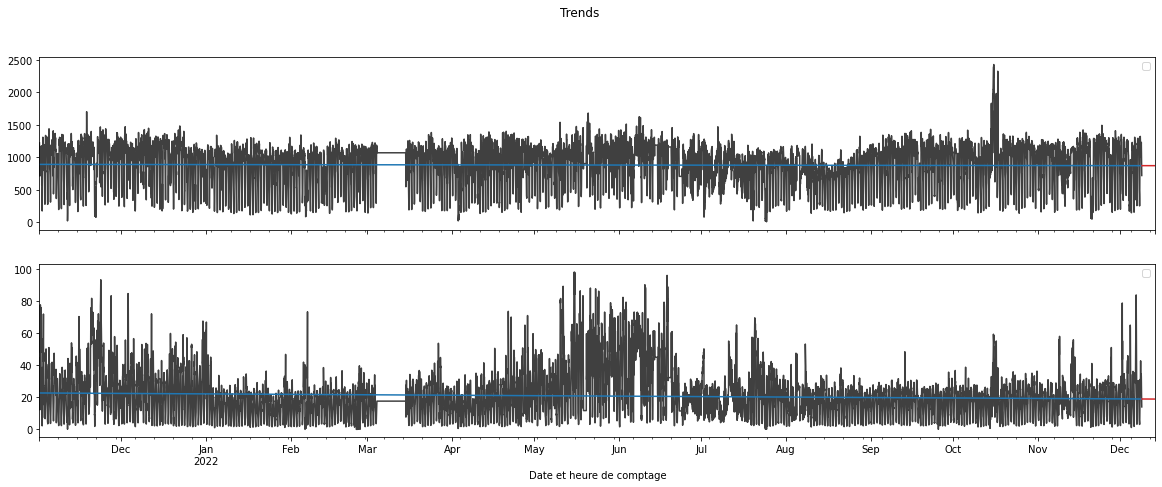

In [ ]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X,y)

y_trend_fit = pd.DataFrame(
    linear_model.predict(X),
    index=y.index,
    columns=y.columns,
)

y_trend_pred = pd.DataFrame(
    linear_model.predict(X_eval),
    index=test_index,
    columns=y.columns,
)

# Plot
axs = y.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_trend_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_trend_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


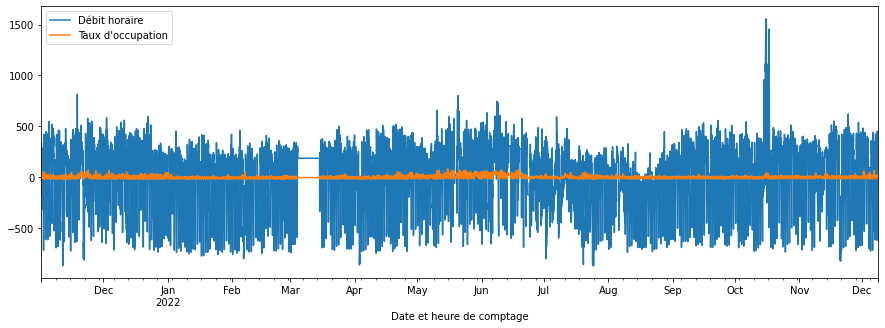

In [ ]:
# We remove the trend

y_detrended = y - y_trend_fit
y_detrended.plot(figsize=(15,5))

### Seasonality

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


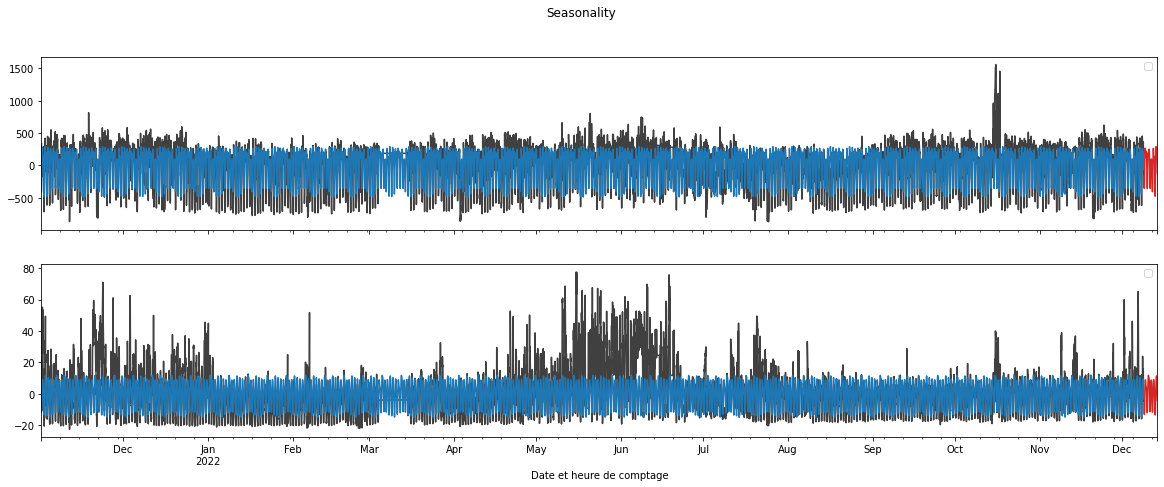

In [ ]:

# Let's now look at seasonality

fourier = CalendarFourier(freq="W", order=15)  

dp_season = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season = dp_season.in_sample() 

# evaluation features
dp_season_eval = DeterministicProcess(
    index=test_index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season_eval = dp_season_eval.in_sample() 


linear_model_season = LinearRegression(fit_intercept=False)
linear_model_season.fit(X_season,y_detrended)

y_season_fit = pd.DataFrame(
    linear_model_season.predict(X_season),
    index=y.index,
    columns=y.columns,
)

y_season_pred = pd.DataFrame(
    linear_model_season.predict(X_season_eval),
    index=test_index,
    columns=y.columns,
)

# Plot
axs = y_detrended.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_season_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_season_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Seasonality")

#### De-seasoned result

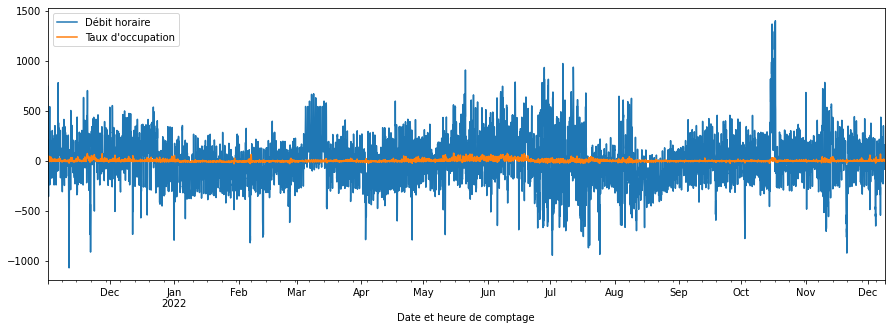

In [ ]:
y_deseasoned = y_detrended - y_season_fit
y_deseasoned.plot(figsize=(15,5))

### Cycles

#### Applying best lag value for debit

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


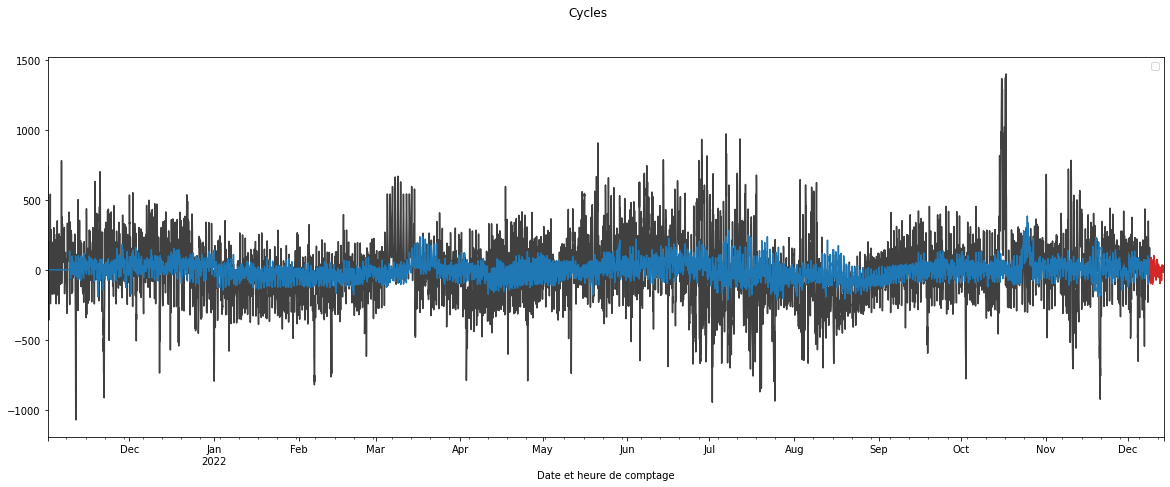

In [ ]:
X_lag_debit = pd.concat([y_deseasoned["Débit horaire"].shift(24*lag) for lag in range(8,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)
X_lag_debit =  X_lag_debit.set_axis([f"Lag_{i}" for i in range(8,11)] , axis=1)

y_cycle_debit = y_deseasoned["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

linear_model_cycle.fit(X_lag_debit,y_cycle_debit)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit),
    index = y_cycle_debit.index,
    columns = ["Débit horaire"],
)

X_lag_debit_eval = pd.DataFrame(
    index = test_index,
    columns = X_lag_debit.columns
)

for i in range(8,11):
  X_lag_debit_eval[f"Lag_{i}"]=list(y_deseasoned.loc[test_index.shift(-24*i)]["Débit horaire"])

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_eval),
    index = test_index,
    columns = ["Débit horaire"],
)

axs = y_cycle_debit.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))

axs = y_cycle_debit_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


#### Applying best lag value for taux

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


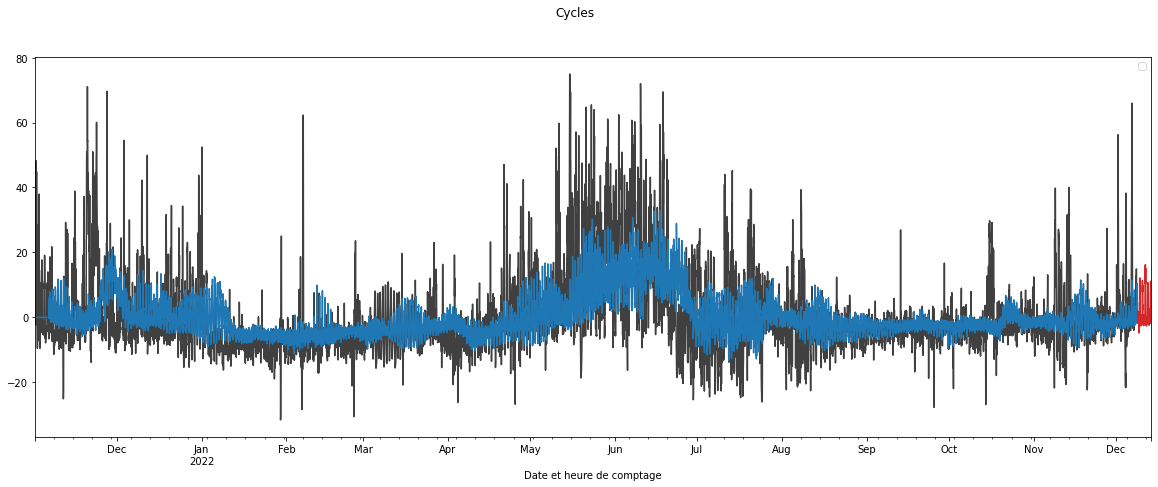

In [ ]:
X_lag_taux = pd.concat([y_deseasoned["Taux d'occupation"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)
X_lag_taux =  X_lag_taux.set_axis([f"Lag_{i}" for i in range(5,11)] , axis=1)


y_cycle_taux = y_deseasoned["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)


linear_model_cycle.fit(X_lag_taux,y_cycle_taux)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux),
    index = y_cycle_taux.index,
    columns = ["Taux d'occupation"],
)

X_lag_taux_eval = pd.DataFrame(
    index = test_index,
    columns = X_lag_taux.columns
)

for i in range(5,11):
  X_lag_taux_eval[f"Lag_{i}"]=list(y_deseasoned.loc[test_index.shift(-24*i)]["Taux d'occupation"])

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_eval),
    index = test_index,
    columns = ["Taux d'occupation"],
)

axs = y_cycle_taux.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_taux_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


### Trend + season + cycles

In [ ]:
y_cycle_pred = pd.concat([y_cycle_taux_pred,y_cycle_debit_pred],axis=1)
y_cycle_pred

Taux d'occupation  Débit horaire
2022-12-09 01:00:00          -1.070823       9.299144
2022-12-09 02:00:00           0.098896      -3.069202
2022-12-09 03:00:00          -1.665543     -34.332595
2022-12-09 04:00:00          -0.423351     -64.107294
2022-12-09 05:00:00          -1.902286     -98.678422
...                                ...            ...
2022-12-13 20:00:00           9.209220      29.725091
2022-12-13 21:00:00           8.907522      -1.174013
2022-12-13 22:00:00           7.152591     -18.805182
2022-12-13 23:00:00           9.841569      -3.498889
2022-12-14 00:00:00           5.674755     -17.776838

[120 rows x 2 columns]

In [ ]:
y_cycle_fit = pd.concat([y_cycle_taux_fit,y_cycle_debit_fit],axis=1)
y_cycle_fit

Taux d'occupation  Débit horaire
Date et heure de comptage                                  
2021-11-01 04:00:00                 0.000000       0.000000
2021-11-01 05:00:00                 0.000000       0.000000
2021-11-01 06:00:00                 0.000000       0.000000
2021-11-01 07:00:00                 0.000000       0.000000
2021-11-01 08:00:00                 0.000000       0.000000
...                                      ...            ...
2022-12-08 20:00:00                 5.742568      48.900221
2022-12-08 21:00:00                10.419680      16.469878
2022-12-08 22:00:00                 3.170441     -36.216729
2022-12-08 23:00:00                 4.568387     -34.868065
2022-12-09 00:00:00                 2.489836      -6.426427

[9669 rows x 2 columns]

In [ ]:
y_pred_deterministic = y_trend_pred + y_season_pred + y_cycle_pred 
y_pred_deterministic

Débit horaire  Taux d'occupation
2022-12-09 01:00:00     710.376612          11.983853
2022-12-09 02:00:00     606.016340          10.478584
2022-12-09 03:00:00     509.041621           6.428678
2022-12-09 04:00:00     451.394627           6.103414
2022-12-09 05:00:00     432.401091           4.059859
...                            ...                ...
2022-12-13 20:00:00    1100.635227          35.126879
2022-12-13 21:00:00    1052.184648          32.688912
2022-12-13 22:00:00     972.591270          28.287204
2022-12-13 23:00:00     881.803092          27.883005
2022-12-14 00:00:00     730.415376          20.355914

[120 rows x 2 columns]

In [ ]:
y_pred_deterministic.to_csv("/content/drive/MyDrive/CentraleSupelec/3A/BCG_datathon/Results/chmps_preds.csv",sep=";")

In [ ]:
y_fit_deterministic = y_trend_fit + y_season_fit + y_cycle_fit
y_fit_deterministic

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00           480.487750          11.099874
2021-11-01 05:00:00           503.905021          11.145087
2021-11-01 06:00:00           575.678557          12.337431
2021-11-01 07:00:00           686.005199          14.567034
2021-11-01 08:00:00           817.022496          17.569469
...                                  ...                ...
2022-12-08 20:00:00          1118.804088          30.101993
2022-12-08 21:00:00          1056.518604          33.112073
2022-12-08 22:00:00           947.613924          23.881964
2022-12-08 23:00:00           867.648911          22.964054
2022-12-09 00:00:00           797.404111          18.279564

[9669 rows x 2 columns]

#### On train set

In [ ]:
rmse(y["Débit horaire"],y_fit_deterministic["Débit horaire"])

218.02269767833602

In [ ]:
rmse(y["Taux d'occupation"],y_fit_deterministic["Taux d'occupation"])

10.610128147344104

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


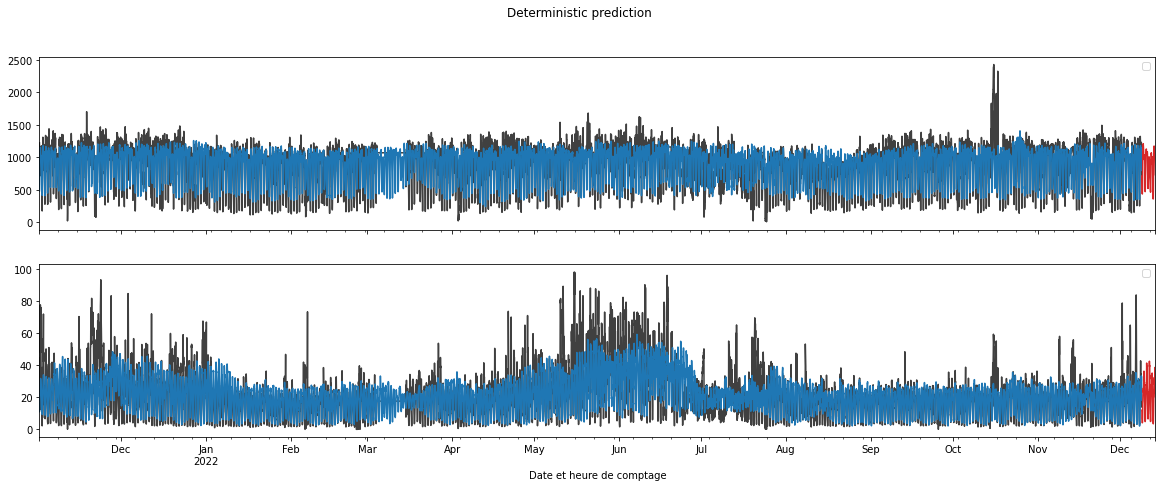

In [ ]:
axs = y.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_fit_deterministic.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred_deterministic.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Deterministic prediction")


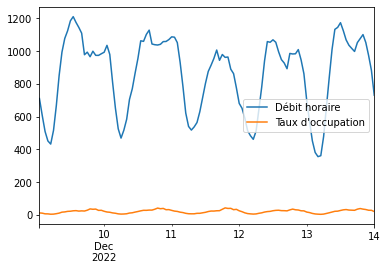

In [ ]:
y_pred_deterministic.plot()

# Saint-Pères

In [ ]:
df_sts_base = df_sts.drop(columns=["Libelle","Etat trafic","Etat arc_Barré", "Etat arc_Invalide"])
df_sts_base.sort_values(by="Date et heure de comptage", inplace=True)
df_sts_base.set_index("Date et heure de comptage",inplace=True)
df_sts_base

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00                163.0            1.94556
2021-11-01 05:00:00                125.0            1.67778
2021-11-01 06:00:00                115.0            1.58444
2021-11-01 07:00:00                129.0            1.56222
2021-11-01 08:00:00                144.0            1.94278
...                                  ...                ...
2022-12-03 20:00:00                615.0           12.91333
2022-12-03 21:00:00                582.0           10.74056
2022-12-03 22:00:00                566.0           10.19723
2022-12-03 23:00:00                493.0            7.23500
2022-12-04 00:00:00                544.0            8.91500

[9164 rows x 2 columns]

### Trend

In [ ]:
y = df_sts_base.copy()

# Create trend features
dp = DeterministicProcess(
    index = y.index,
    constant=True,
    order=1,
    drop=True
)
X = dp.in_sample()

In [ ]:
X_train,X_test,y_train,y_test = timeseries_train_test_split(X, y, test_size=0.1)

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


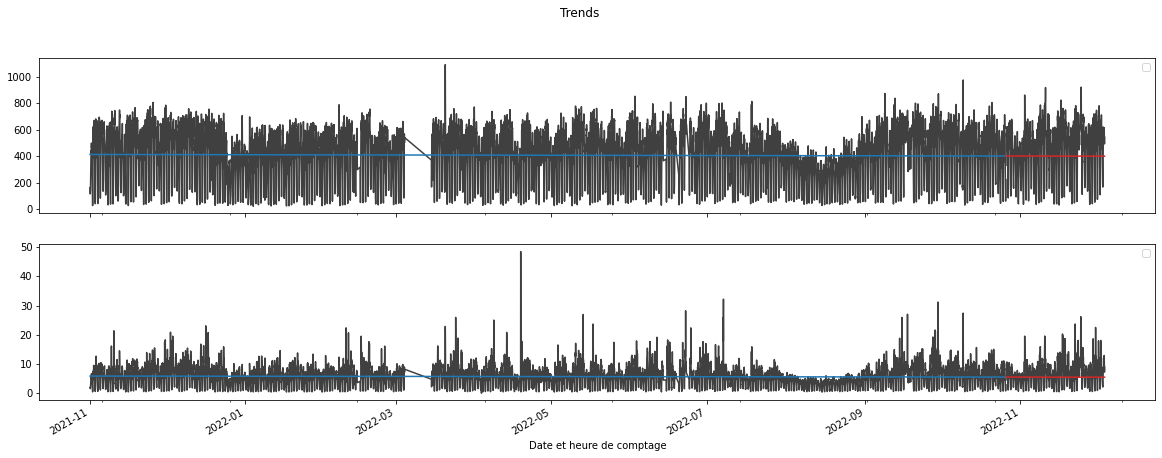

In [ ]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X_train,y_train)

y_trend_fit = pd.DataFrame(
    linear_model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_trend_pred = pd.DataFrame(
    linear_model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_trend_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_trend_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


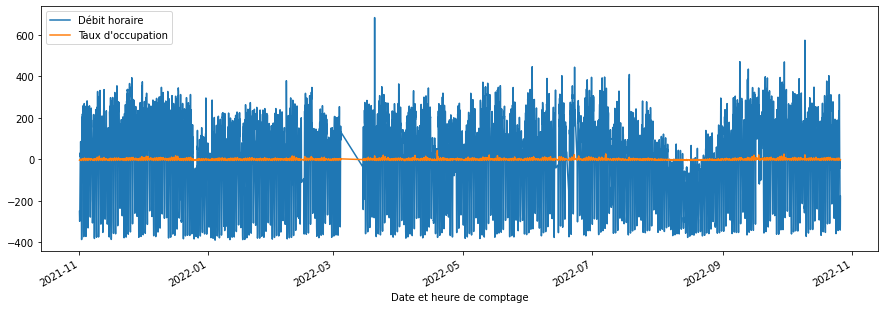

In [ ]:
# We remove the trend

y_detrended = y_train - y_trend_fit
y_detrended.plot(figsize=(15,5))

In [ ]:
y_detrended_test = y_test - y_trend_pred


### Seasonality

#### Testing different fourier order values

In [ ]:
def testing_best_fourier_order(freq_type, order):

  fourier = CalendarFourier(freq=freq_type, order=order)  # 10 sin/cos pairs for "W"eekly seasonality

  dp_season = DeterministicProcess(
      index=y.index,
      constant=True,               # dummy feature for bias (y-intercept)
      order=1,                     # trend (order 1 means linear)
      seasonal=False,               # weekly seasonality (indicators)
      additional_terms=[fourier],  # annual seasonality (fourier)
      drop=True,                   # drop terms to avoid collinearity
  )

  X_season = dp_season.in_sample() 

  X_train_season,X_test_season,y_train,y_test = timeseries_train_test_split(X_season, y, test_size=0.1)

  linear_model_season = LinearRegression(fit_intercept=False)
  linear_model_season.fit(X_train_season,y_detrended)

  y_season_fit = pd.DataFrame(
      linear_model_season.predict(X_train_season),
      index=y_train.index,
      columns=y_train.columns,
  )

  y_season_pred = pd.DataFrame(
      linear_model_season.predict(X_test_season),
      index=y_test.index,
      columns=y_test.columns,
  )
  print(f"RMSE on test set is for a Fourier order of {order} is: ", rmse(y_detrended_test,y_season_pred))
  print(f"RMSE on train set is for a Fourier order of {order} is: ", rmse(y_detrended,y_season_fit))

In [ ]:
for i in range(1,30):
  testing_best_fourier_order(freq_type="W",order=i)

RMSE on test set is for a Fourier order of 1 is:  142.9597381553115
RMSE on train set is for a Fourier order of 1 is:  138.80881422092511
RMSE on test set is for a Fourier order of 2 is:  143.06418722053388
RMSE on train set is for a Fourier order of 2 is:  138.5248965197996
RMSE on test set is for a Fourier order of 3 is:  143.0486255906042
RMSE on train set is for a Fourier order of 3 is:  138.52044558786278
RMSE on test set is for a Fourier order of 4 is:  142.95893796754703
RMSE on train set is for a Fourier order of 4 is:  138.47119419499165
RMSE on test set is for a Fourier order of 5 is:  142.73917217733268
RMSE on train set is for a Fourier order of 5 is:  137.98129300693608
RMSE on test set is for a Fourier order of 6 is:  139.57803041369488
RMSE on train set is for a Fourier order of 6 is:  136.20963798051616
RMSE on test set is for a Fourier order of 7 is:  74.16593851779997
RMSE on train set is for a Fourier order of 7 is:  76.7976040768688
RMSE on test set is for a Fourier

Let's take 22

#### Choosing best value from "grid search"

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


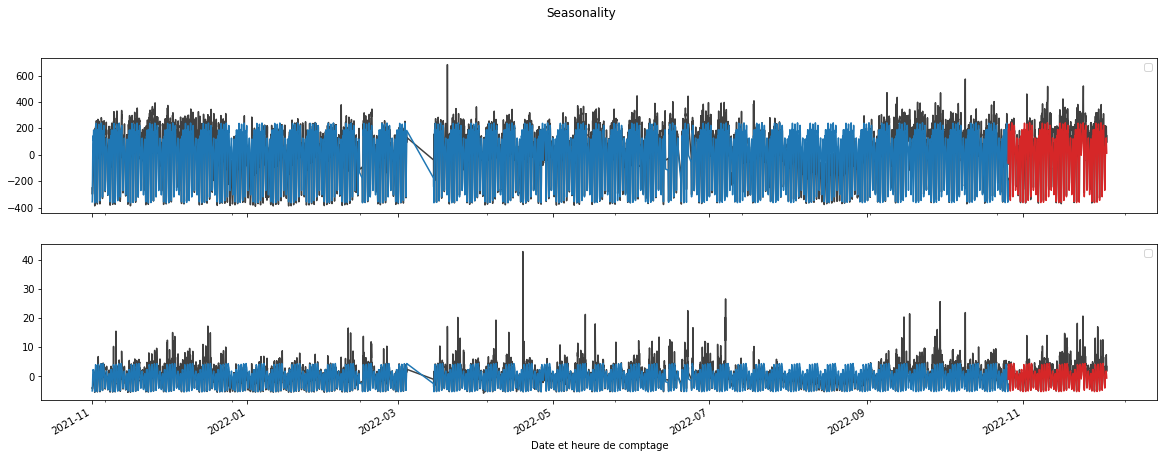

In [ ]:

# Let's now look at seasonality

fourier = CalendarFourier(freq="W", order=22)  

dp_season = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season = dp_season.in_sample() 

X_train_season,X_test_season,y_train,y_test = timeseries_train_test_split(X_season, y, test_size=0.1)

linear_model_season = LinearRegression(fit_intercept=False)
linear_model_season.fit(X_train_season,y_detrended)

y_season_fit = pd.DataFrame(
    linear_model_season.predict(X_train_season),
    index=y_train.index,
    columns=y_train.columns,
)

y_season_pred = pd.DataFrame(
    linear_model_season.predict(X_test_season),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_detrended.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_detrended_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_season_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_season_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Seasonality")

#### De-seasoned result

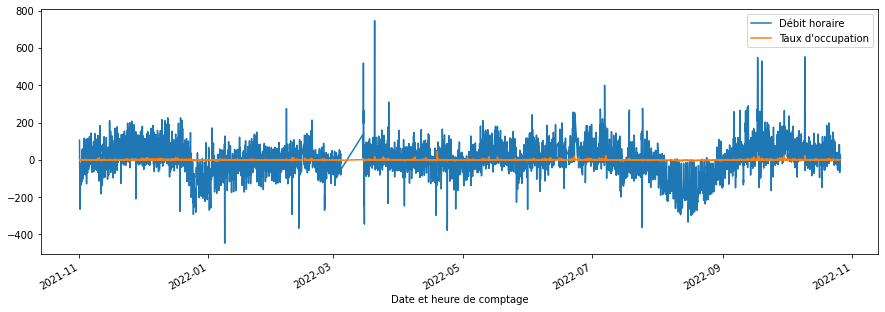

In [ ]:
y_deseasoned = y_detrended - y_season_fit
y_deseasoned.plot(figsize=(15,5))

In [ ]:
y_deseasoned_test = y_detrended_test - y_season_pred


### Cycles

In [ ]:
y_deseasoned_total = pd.concat([y_deseasoned,y_deseasoned_test])
y_deseasoned_total

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00           105.449929           1.055407
2021-11-01 05:00:00            61.739128           0.750491
2021-11-01 06:00:00             0.671204           0.019029
2021-11-01 07:00:00           -77.641560          -1.224089
2021-11-01 08:00:00          -178.011710          -2.428506
...                                  ...                ...
2022-12-03 20:00:00            98.910769           5.845740
2022-12-03 21:00:00            92.507883           4.250167
2022-12-03 22:00:00           107.265768           4.364012
2022-12-03 23:00:00            60.321359           1.944689
2022-12-04 00:00:00           130.774284           3.981620

[9164 rows x 2 columns]

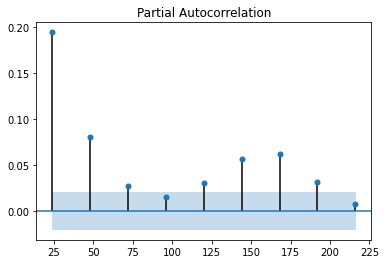

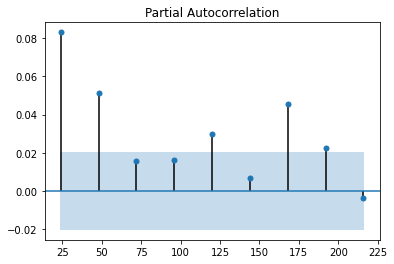

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_pacf(y_deseasoned_total["Débit horaire"],lags=[24*i for i in range(1,10)])
_ = plot_pacf(y_deseasoned_total["Taux d'occupation"],lags=[24*i for i in range(1,10)])

#### Choosing best lag features for debit

In [ ]:
def choose_best_lag(lag):
  X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag)],axis=1)
  X_lag_debit  = X_lag_debit.fillna(0.0)

  y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

  linear_model_cycle = LinearRegression(fit_intercept=False)

  X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

  linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

  y_cycle_debit_fit = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_debit_train),
      index = y_cycle_debit_train.index,
      columns = ["Débit horaire"],
  )

  y_cycle_debit_pred = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_debit_test),
      index = y_cycle_debit_test.index,
      columns = ["Débit horaire"],
  )

  print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test,y_cycle_debit_pred))
  print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

In [ ]:
for lag in range(5,14):
  choose_best_lag(lag)

RMSE on test set is for a lag of 5 is:  74.59195890711824
RMSE on train set is for a lag of 5 is:  74.49727847389038
RMSE on test set is for a lag of 6 is:  74.32732413522646
RMSE on train set is for a lag of 6 is:  74.09715773961678
RMSE on test set is for a lag of 7 is:  74.76639925292038
RMSE on train set is for a lag of 7 is:  73.5469301101157
RMSE on test set is for a lag of 8 is:  76.07968386013154
RMSE on train set is for a lag of 8 is:  75.9420154185411
RMSE on test set is for a lag of 9 is:  78.16305283225806
RMSE on train set is for a lag of 9 is:  78.16455298114317
RMSE on test set is for a lag of 10 is:  77.8141874645139
RMSE on train set is for a lag of 10 is:  78.76265853628908
RMSE on test set is for a lag of 11 is:  76.70082862418556
RMSE on train set is for a lag of 11 is:  79.25812653197339
RMSE on test set is for a lag of 12 is:  77.18110288714178
RMSE on train set is for a lag of 12 is:  79.41598669274869
RMSE on test set is for a lag of 13 is:  76.23318128202573
RM

In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(8,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  75.97354831416466
RMSE on train set is for a lag of 13 is:  75.02358928661495


In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  71.58577427854952
RMSE on train set is for a lag of 13 is:  69.80631402787878


In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(5,8)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  71.87054217395473
RMSE on train set is for a lag of 13 is:  70.16661838336351


In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(7,9)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  74.10603495694747
RMSE on train set is for a lag of 13 is:  72.36867323003213


#### Applying best lag value for debit

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


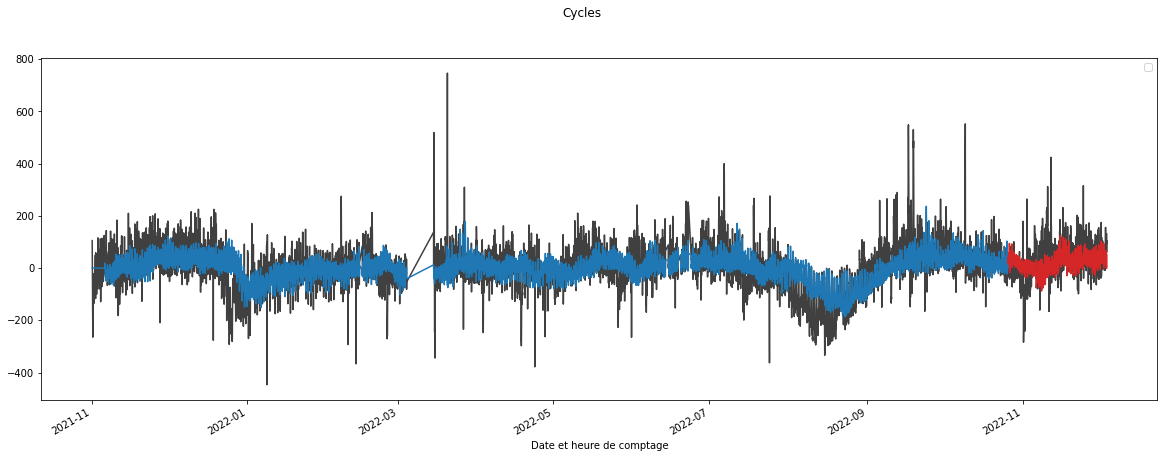

In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

axs = y_cycle_debit_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_debit_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


#### Choosing best lag features for taux

In [ ]:
def choose_best_lag(lag):
  X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag)],axis=1)
  X_lag_taux  = X_lag_taux.fillna(0.0)

  y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

  linear_model_cycle = LinearRegression(fit_intercept=False)

  X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

  linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

  y_cycle_taux_fit = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_taux_train),
      index = y_cycle_taux_train.index,
      columns = ["Taux d'occupation"],
  )

  y_cycle_taux_pred = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_taux_test),
      index = y_cycle_taux_test.index,
      columns = ["Taux d'occupation"],
  )
  print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
  print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

In [ ]:
for i in range(5,14):
  choose_best_lag(i)

RMSE on test set is for a lag of 5 is:  2.0949799819302832
RMSE on train set is for a lag of 5 is:  1.8765896917680858
RMSE on test set is for a lag of 6 is:  2.130618750906843
RMSE on train set is for a lag of 6 is:  1.8732092761248722
RMSE on test set is for a lag of 7 is:  2.1114501027397936
RMSE on train set is for a lag of 7 is:  1.8660692805637282
RMSE on test set is for a lag of 8 is:  2.125309538171993
RMSE on train set is for a lag of 8 is:  1.8931330956201073
RMSE on test set is for a lag of 9 is:  2.14137610775066
RMSE on train set is for a lag of 9 is:  1.915252010514647
RMSE on test set is for a lag of 10 is:  2.149587869166288
RMSE on train set is for a lag of 10 is:  1.918173054343635
RMSE on test set is for a lag of 11 is:  2.15809502706695
RMSE on train set is for a lag of 11 is:  1.9086964491122578
RMSE on test set is for a lag of 12 is:  2.140415738124063
RMSE on train set is for a lag of 12 is:  1.9118155585630285
RMSE on test set is for a lag of 13 is:  2.153213352

In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(8,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  2.1068031542109797
RMSE on train set is for a lag of 13 is:  1.87568228023564


In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  2.046464580546759
RMSE on train set is for a lag of 13 is:  1.8007603271521082


In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,8)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  2.058671260406937
RMSE on train set is for a lag of 13 is:  1.8098717723457949


In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,9)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  2.0484614922404907
RMSE on train set is for a lag of 13 is:  1.801933917497084


#### Applying best lag value for taux

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


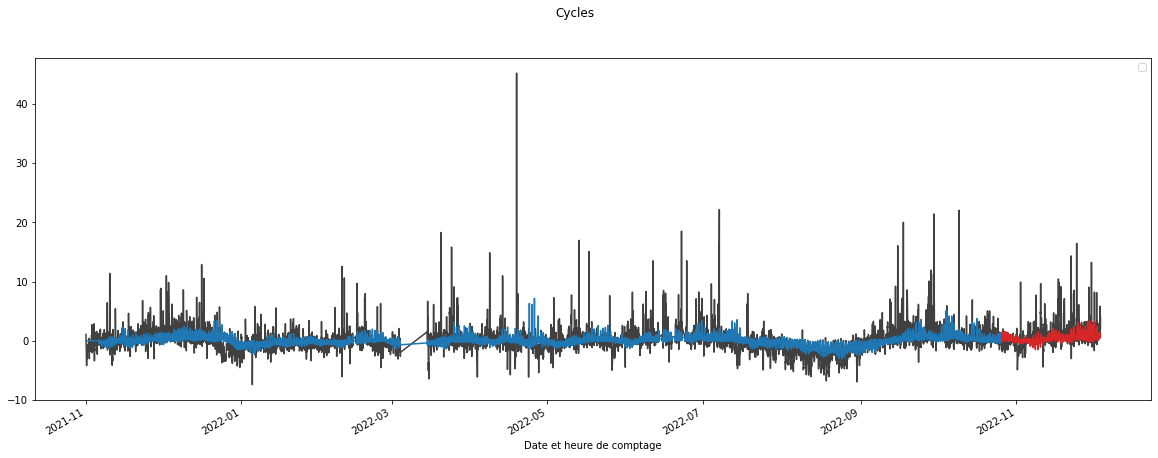

In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)

axs = y_cycle_taux_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_taux_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


In [ ]:
y_deseasoned_debit = y_deseasoned.drop(columns=["Taux d'occupation"])
y_deseasoned_taux = y_deseasoned.drop(columns=["Débit horaire"])

y_deseasoned_debit_test = y_deseasoned_test.drop(columns=["Taux d'occupation"])
y_deseasoned_taux_test = y_deseasoned_test.drop(columns=["Débit horaire"])

In [ ]:
y_residual_debit_train = y_deseasoned_debit - y_cycle_debit_fit
y_residual_debit_test = y_deseasoned_debit_test - y_cycle_debit_pred

y_residual_taux_train = y_deseasoned_taux - y_cycle_taux_fit
y_residual_taux_test = y_deseasoned_taux_test - y_cycle_taux_pred

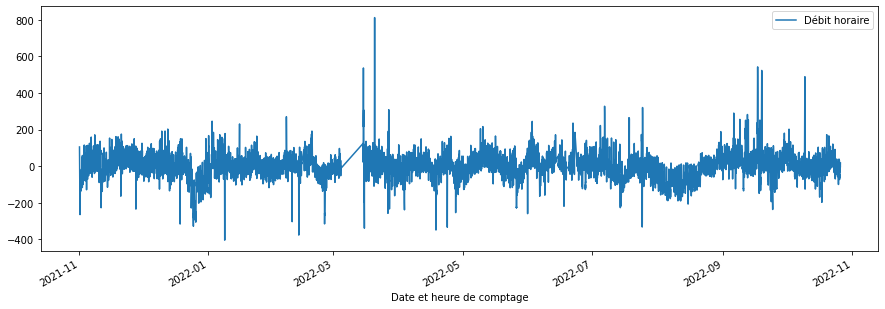

In [ ]:
y_residual_debit_train.plot(figsize=(15,5))

### Trend + season + cycles

In [ ]:
y_cycle_pred = pd.concat([y_cycle_taux_pred,y_cycle_debit_pred],axis=1)
y_cycle_pred

Taux d'occupation  Débit horaire
Date et heure de comptage                                  
2022-10-26 08:00:00                 0.250264      19.812350
2022-10-26 09:00:00                 0.377234      43.363993
2022-10-26 10:00:00                -0.216717      27.202733
2022-10-26 11:00:00                 0.968599      14.685753
2022-10-26 12:00:00                 1.502019      23.971659
...                                      ...            ...
2022-12-03 20:00:00                 1.102487      67.738883
2022-12-03 21:00:00                 0.755505      30.011571
2022-12-03 22:00:00                 0.520503      -1.102773
2022-12-03 23:00:00                 0.490784       9.572610
2022-12-04 00:00:00                 0.827588      51.091715

[917 rows x 2 columns]

In [ ]:
y_cycle_fit = pd.concat([y_cycle_taux_fit,y_cycle_debit_fit],axis=1)
y_cycle_fit

Taux d'occupation  Débit horaire
Date et heure de comptage                                  
2021-11-01 04:00:00                 0.000000       0.000000
2021-11-01 05:00:00                 0.000000       0.000000
2021-11-01 06:00:00                 0.000000       0.000000
2021-11-01 07:00:00                 0.000000       0.000000
2021-11-01 08:00:00                 0.000000       0.000000
...                                      ...            ...
2022-10-26 03:00:00                 0.167915      18.613528
2022-10-26 04:00:00                 0.194554      10.271746
2022-10-26 05:00:00                 0.260912      11.615601
2022-10-26 06:00:00                 0.146371       1.759843
2022-10-26 07:00:00                 0.019901       2.090250

[8247 rows x 2 columns]

In [ ]:
y_pred_deterministic = y_trend_pred + y_season_pred + y_cycle_pred 
y_pred_deterministic

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2022-10-26 08:00:00           359.235507           4.819225
2022-10-26 09:00:00           510.621220           7.012298
2022-10-26 10:00:00           583.571814           8.072115
2022-10-26 11:00:00           609.787305          10.257938
2022-10-26 12:00:00           617.335454          11.174484
...                                  ...                ...
2022-12-03 20:00:00           583.828115           8.170077
2022-12-03 21:00:00           519.503688           7.245897
2022-12-03 22:00:00           457.631460           6.353721
2022-12-03 23:00:00           442.251251           5.781094
2022-12-04 00:00:00           464.317431           5.760968

[917 rows x 2 columns]

In [ ]:
y_fit_deterministic = y_trend_fit + y_season_fit + y_cycle_fit
y_fit_deterministic

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00            57.550071           0.890153
2021-11-01 05:00:00            63.260872           0.927289
2021-11-01 06:00:00           114.328796           1.565411
2021-11-01 07:00:00           206.641560           2.786309
2021-11-01 08:00:00           322.011710           4.371286
...                                  ...                ...
2022-10-26 03:00:00           133.092534           1.557050
2022-10-26 04:00:00            64.101658           0.771682
2022-10-26 05:00:00            54.606786           0.638836
2022-10-26 06:00:00            97.014535           1.187075
2022-10-26 07:00:00           205.294073           2.562527

[8247 rows x 2 columns]

In [ ]:
X = df_sts_base
y = df_sts_base

_,_,y_train,y_test = timeseries_train_test_split(X,y,test_size=0.1)

#### On test set

In [ ]:
rmse(y_test,y_pred_deterministic)

156.4959043895455

In [ ]:
rmse(y_test["Taux d'occupation"],y_pred_deterministic["Taux d'occupation"])

2.046464580546759

In [ ]:
rmse(y_test["Débit horaire"],y_pred_deterministic["Débit horaire"])

71.58577427854952

#### On train set

In [ ]:
rmse(y_train["Débit horaire"],y_fit_deterministic["Débit horaire"])

69.80631402787878

In [ ]:
rmse(y_train["Taux d'occupation"],y_fit_deterministic["Taux d'occupation"])

1.8007603271521084

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


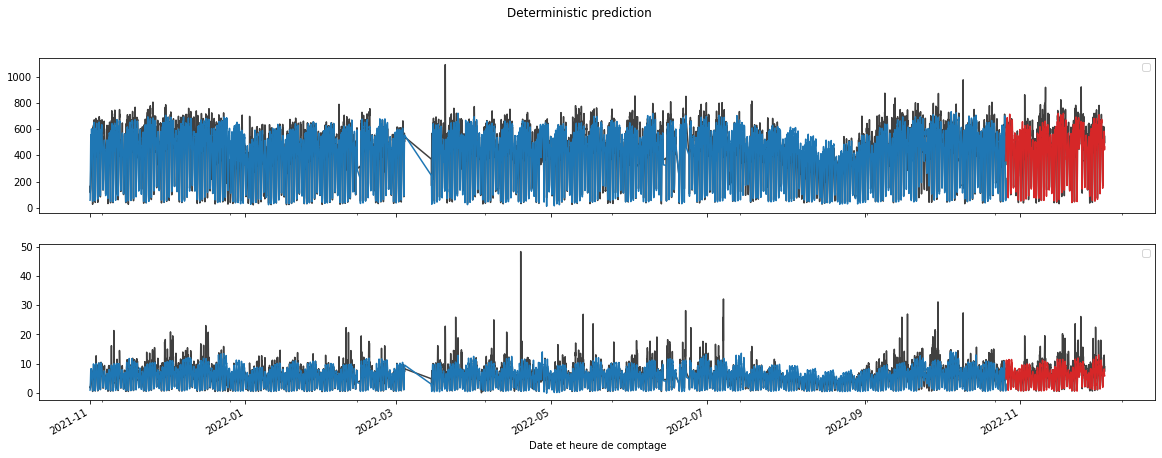

In [ ]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit_deterministic.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred_deterministic.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Deterministic prediction")


# Saint-Pères FINAL (with as freq)

In [ ]:
df_sts_base = df_sts.drop(columns=["Libelle","Etat trafic","Etat arc_Barré", "Etat arc_Invalide"])
df_sts_base.sort_values(by="Date et heure de comptage", inplace=True)
df_sts_base.set_index("Date et heure de comptage",inplace=True)
df_sts_base

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00                163.0            1.94556
2021-11-01 05:00:00                125.0            1.67778
2021-11-01 06:00:00                115.0            1.58444
2021-11-01 07:00:00                129.0            1.56222
2021-11-01 08:00:00                144.0            1.94278
...                                  ...                ...
2022-12-08 20:00:00                806.0           10.53389
2022-12-08 21:00:00                684.0            9.73722
2022-12-08 22:00:00                533.0            6.78833
2022-12-08 23:00:00                494.0            6.18167
2022-12-09 00:00:00                578.0            7.37667

[9284 rows x 2 columns]

In [ ]:
df_sts_base_freq = df_sts_base.asfreq('H', method= 'ffill')
df_sts_base_freq

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00                163.0            1.94556
2021-11-01 05:00:00                125.0            1.67778
2021-11-01 06:00:00                115.0            1.58444
2021-11-01 07:00:00                129.0            1.56222
2021-11-01 08:00:00                144.0            1.94278
...                                  ...                ...
2022-12-08 20:00:00                806.0           10.53389
2022-12-08 21:00:00                684.0            9.73722
2022-12-08 22:00:00                533.0            6.78833
2022-12-08 23:00:00                494.0            6.18167
2022-12-09 00:00:00                578.0            7.37667

[9669 rows x 2 columns]

### Trend

In [ ]:
y = df_sts_base_freq.copy()

# Create trend features
dp = DeterministicProcess(
    index = y.index,
    constant=True,
    order=1,
    drop=True
)
X = dp.in_sample()

In [ ]:
start="2022-12-09 01:00:00"
end="2022-12-14 00:00:00"
test_index = pd.date_range(start=start, end=end,freq='H')

In [ ]:
# Create trend features for evaluation set
dp_eval = DeterministicProcess(
    index = test_index,
    constant=True,
    order=1,
    drop=True
)
X_eval = dp_eval.in_sample()
X_eval["trend"] = X_eval["trend"]+len(X)

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


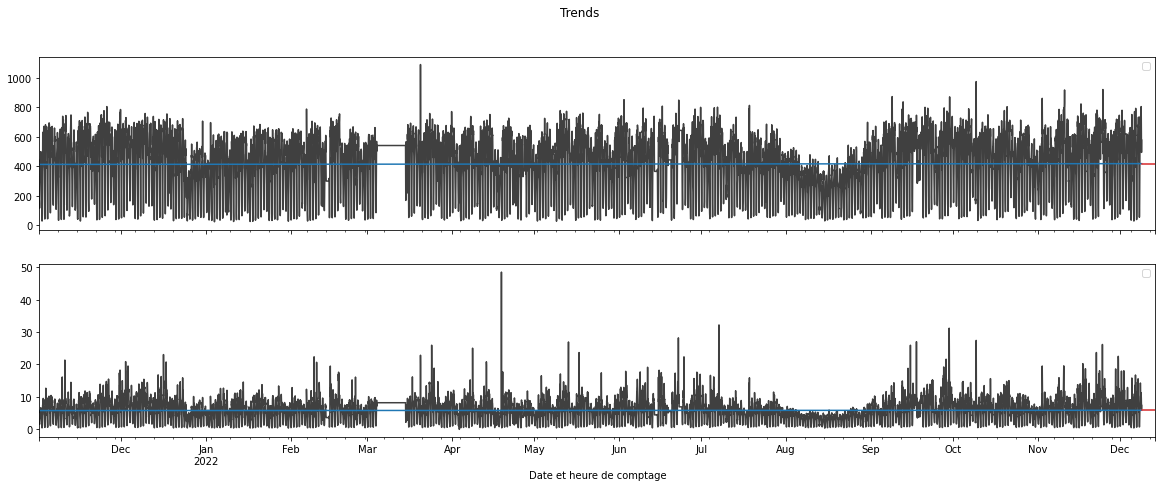

In [ ]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X,y)

y_trend_fit = pd.DataFrame(
    linear_model.predict(X),
    index=y.index,
    columns=y.columns,
)

y_trend_pred = pd.DataFrame(
    linear_model.predict(X_eval),
    index=test_index,
    columns=y.columns,
)

# Plot
axs = y.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_trend_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_trend_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


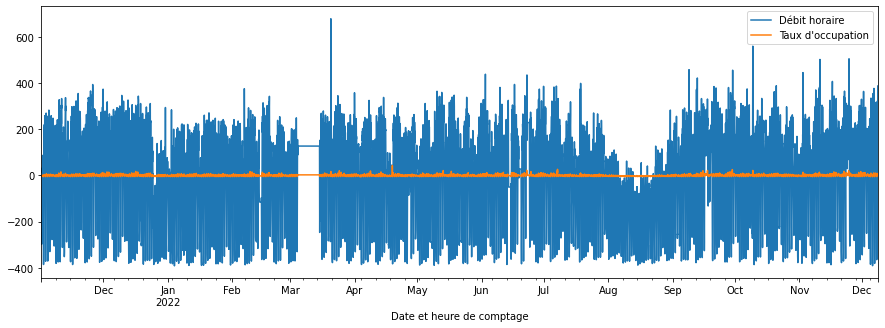

In [ ]:
# We remove the trend

y_detrended = y - y_trend_fit
y_detrended.plot(figsize=(15,5))

### Seasonality

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


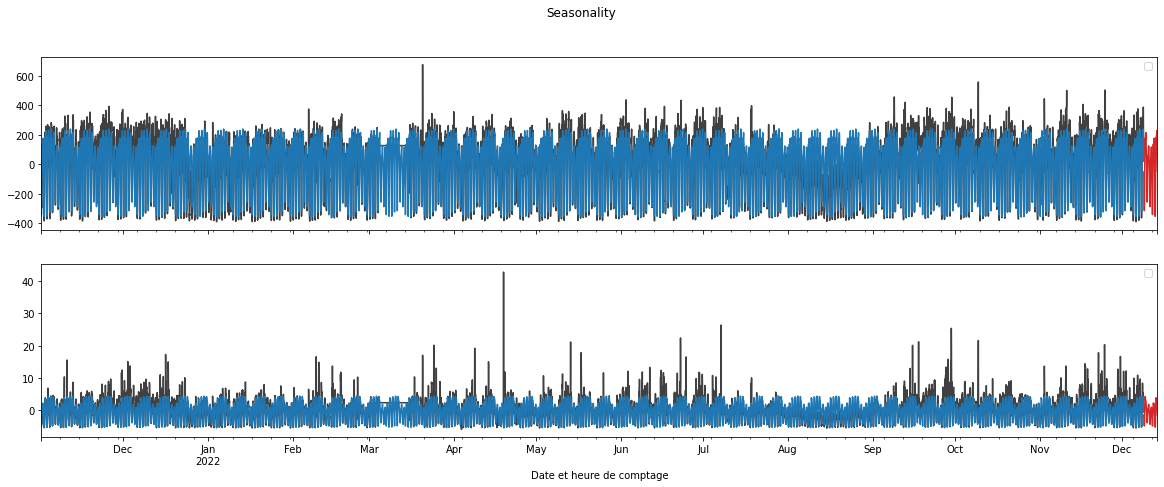

In [ ]:

# Let's now look at seasonality

fourier = CalendarFourier(freq="W", order=22)  

dp_season = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season = dp_season.in_sample() 

# evaluation features
dp_season_eval = DeterministicProcess(
    index=test_index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season_eval = dp_season_eval.in_sample() 


linear_model_season = LinearRegression(fit_intercept=False)
linear_model_season.fit(X_season,y_detrended)

y_season_fit = pd.DataFrame(
    linear_model_season.predict(X_season),
    index=y.index,
    columns=y.columns,
)

y_season_pred = pd.DataFrame(
    linear_model_season.predict(X_season_eval),
    index=test_index,
    columns=y.columns,
)

# Plot
axs = y_detrended.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_season_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_season_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Seasonality")

#### De-seasoned result

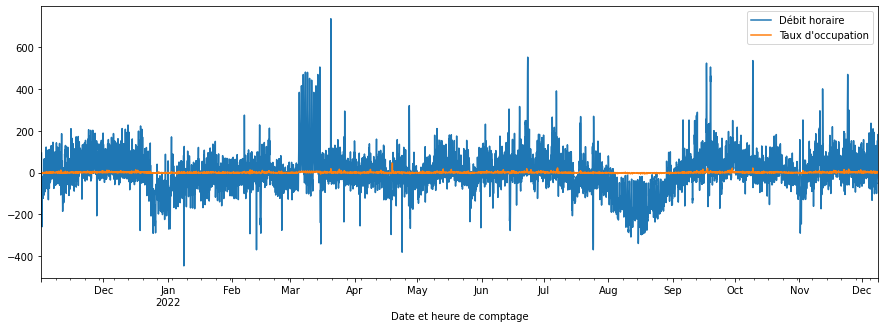

In [ ]:
y_deseasoned = y_detrended - y_season_fit
y_deseasoned.plot(figsize=(15,5))

### Cycles

#### Applying best lag value for debit

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


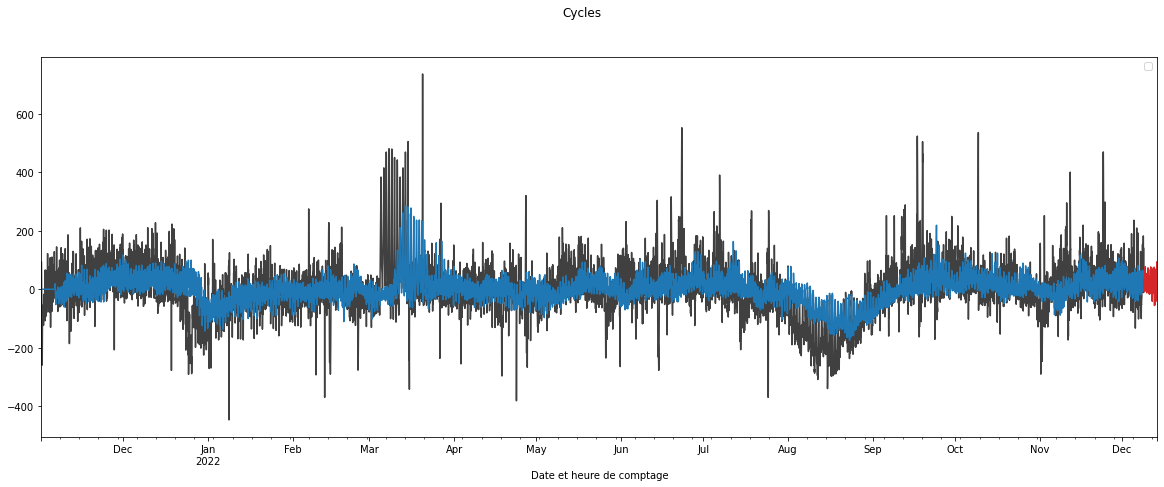

In [ ]:
X_lag_debit = pd.concat([y_deseasoned["Débit horaire"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)
X_lag_debit =  X_lag_debit.set_axis([f"Lag_{i}" for i in range(5,11)] , axis=1)

y_cycle_debit = y_deseasoned["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

linear_model_cycle.fit(X_lag_debit,y_cycle_debit)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit),
    index = y_cycle_debit.index,
    columns = ["Débit horaire"],
)

X_lag_debit_eval = pd.DataFrame(
    index = test_index,
    columns = X_lag_debit.columns
)

for i in range(5,11):
  X_lag_debit_eval[f"Lag_{i}"]=list(y_deseasoned.loc[test_index.shift(-24*i)]["Débit horaire"])

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_eval),
    index = test_index,
    columns = ["Débit horaire"],
)

axs = y_cycle_debit.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))

axs = y_cycle_debit_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


#### Applying best lag value for taux

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


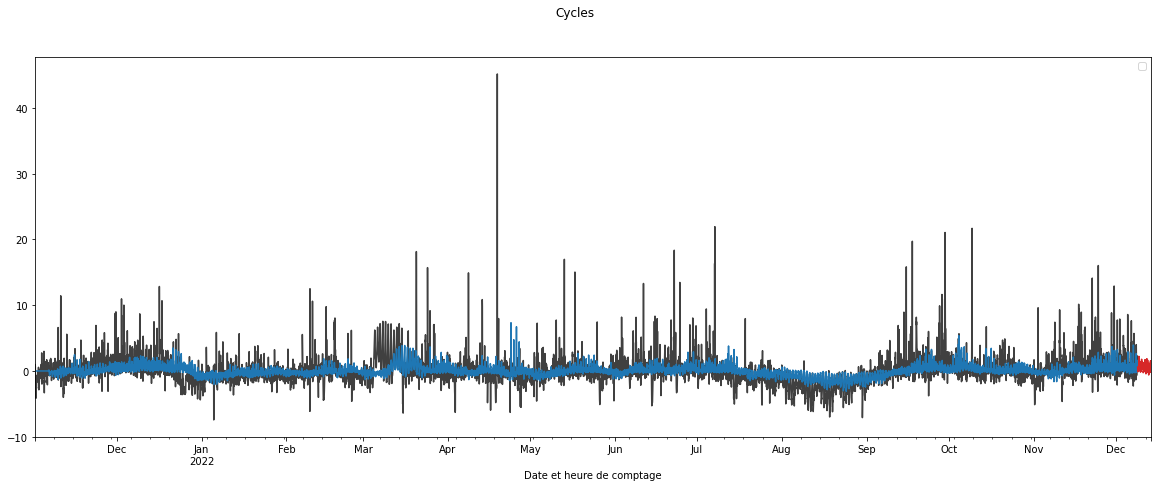

In [ ]:
X_lag_taux = pd.concat([y_deseasoned["Taux d'occupation"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)
X_lag_taux =  X_lag_taux.set_axis([f"Lag_{i}" for i in range(5,11)] , axis=1)


y_cycle_taux = y_deseasoned["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)


linear_model_cycle.fit(X_lag_taux,y_cycle_taux)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux),
    index = y_cycle_taux.index,
    columns = ["Taux d'occupation"],
)

X_lag_taux_eval = pd.DataFrame(
    index = test_index,
    columns = X_lag_taux.columns
)

for i in range(5,11):
  X_lag_taux_eval[f"Lag_{i}"]=list(y_deseasoned.loc[test_index.shift(-24*i)]["Taux d'occupation"])

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_eval),
    index = test_index,
    columns = ["Taux d'occupation"],
)

axs = y_cycle_taux.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_taux_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


### Trend + season + cycles

In [ ]:
y_cycle_pred = pd.concat([y_cycle_taux_pred,y_cycle_debit_pred],axis=1)
y_cycle_pred

Taux d'occupation  Débit horaire
2022-12-09 01:00:00           0.595935      36.007374
2022-12-09 02:00:00          -0.050409       3.662088
2022-12-09 03:00:00          -0.026875       9.159051
2022-12-09 04:00:00           0.114917      14.948476
2022-12-09 05:00:00           0.098822       8.897812
...                                ...            ...
2022-12-13 20:00:00           1.229906      94.280232
2022-12-13 21:00:00           0.827184      46.908097
2022-12-13 22:00:00          -0.223436     -41.769054
2022-12-13 23:00:00          -0.029192     -17.927798
2022-12-14 00:00:00           0.645461      51.936265

[120 rows x 2 columns]

In [ ]:
y_cycle_fit = pd.concat([y_cycle_taux_fit,y_cycle_debit_fit],axis=1)
y_cycle_fit

Taux d'occupation  Débit horaire
Date et heure de comptage                                  
2021-11-01 04:00:00                 0.000000       0.000000
2021-11-01 05:00:00                 0.000000       0.000000
2021-11-01 06:00:00                 0.000000       0.000000
2021-11-01 07:00:00                 0.000000       0.000000
2021-11-01 08:00:00                 0.000000       0.000000
...                                      ...            ...
2022-12-08 20:00:00                 1.637931      61.395160
2022-12-08 21:00:00                 1.218423      46.939727
2022-12-08 22:00:00                 0.594210       7.283474
2022-12-08 23:00:00                 0.218999       3.036023
2022-12-09 00:00:00                 1.104168      55.645365

[9669 rows x 2 columns]

In [ ]:
y_pred_deterministic = y_trend_pred + y_season_pred + y_cycle_pred 
y_pred_deterministic

Débit horaire  Taux d'occupation
2022-12-09 01:00:00     400.944174           5.102236
2022-12-09 02:00:00     281.392694           3.436056
2022-12-09 03:00:00     199.481361           2.357974
2022-12-09 04:00:00     139.286615           1.590662
2022-12-09 05:00:00     110.671214           1.204735
...                            ...                ...
2022-12-13 20:00:00     696.013946           8.872659
2022-12-13 21:00:00     596.695820           7.498427
2022-12-13 22:00:00     450.426822           5.574522
2022-12-13 23:00:00     415.703445           5.052709
2022-12-14 00:00:00     422.633989           5.074260

[120 rows x 2 columns]

In [ ]:
y_pred_deterministic.to_csv("/content/drive/MyDrive/CentraleSupelec/3A/BCG_datathon/Results/sts_preds.csv",sep=";")

In [ ]:
y_fit_deterministic = y_trend_fit + y_season_fit + y_cycle_fit
y_fit_deterministic

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00            69.556016           0.989856
2021-11-01 05:00:00            75.903728           1.023803
2021-11-01 06:00:00           125.564985           1.637377
2021-11-01 07:00:00           214.618422           2.822319
2021-11-01 08:00:00           325.626747           4.370778
...                                  ...                ...
2022-12-08 20:00:00           684.758358           9.900300
2022-12-08 21:00:00           633.571529           8.664907
2022-12-08 22:00:00           551.667382           7.288006
2022-12-08 23:00:00           499.650822           6.236520
2022-12-09 00:00:00           493.861178           6.431740

[9669 rows x 2 columns]

#### On train set

In [ ]:
rmse(y["Débit horaire"],y_fit_deterministic["Débit horaire"])

79.47471290057628

In [ ]:
rmse(y["Taux d'occupation"],y_fit_deterministic["Taux d'occupation"])

1.8984980664960749

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


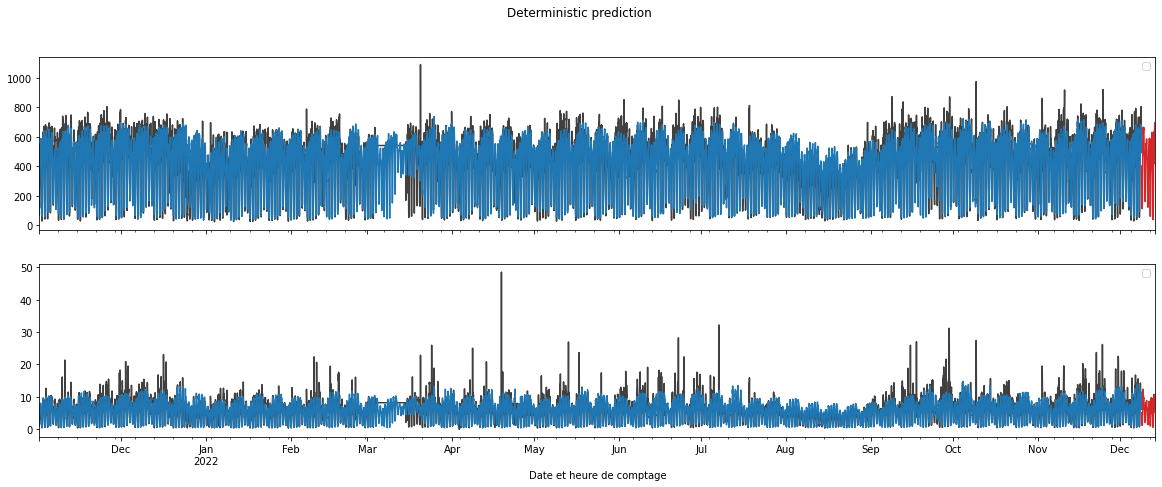

In [ ]:
axs = y.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_fit_deterministic.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred_deterministic.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Deterministic prediction")


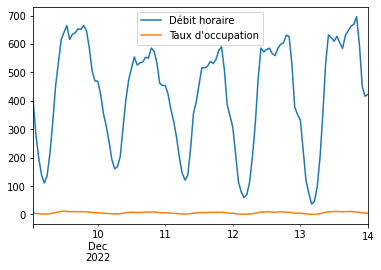

In [ ]:
y_pred_deterministic.plot()

# Convention

In [ ]:
df_cnvtn_base = df_cnvtn.drop(columns=["Libelle","Etat trafic","Etat arc_Barré", "Etat arc_Invalide"])
df_cnvtn_base.sort_values(by="Date et heure de comptage", inplace=True)
df_cnvtn_base.set_index("Date et heure de comptage",inplace=True)
df_cnvtn_base

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00           145.000000            0.91611
2021-11-01 05:00:00           127.000000            0.76222
2021-11-01 06:00:00           136.000000            0.69556
2021-11-01 07:00:00           132.000000            0.87167
2021-11-01 08:00:00           185.000000            1.24000
...                                  ...                ...
2022-12-03 20:00:00           290.846154            6.75556
2022-12-03 21:00:00           257.076923            4.73500
2022-12-03 22:00:00           223.307692            2.65722
2022-12-03 23:00:00           189.538462            2.48611
2022-12-04 00:00:00           155.769231            2.84000

[9198 rows x 2 columns]

### Trend

In [ ]:
y = df_cnvtn_base.copy()

# Create trend features
dp = DeterministicProcess(
    index = y.index,
    constant=True,
    order=1,
    drop=True
)
X = dp.in_sample()

In [ ]:
X_train,X_test,y_train,y_test = timeseries_train_test_split(X, y, test_size=0.1)

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


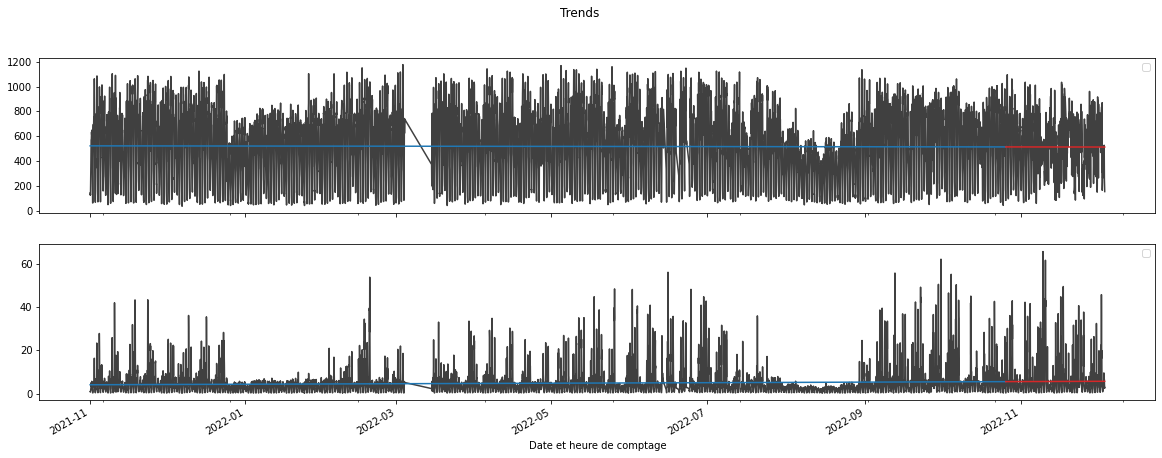

In [ ]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X_train,y_train)

y_trend_fit = pd.DataFrame(
    linear_model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_trend_pred = pd.DataFrame(
    linear_model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_trend_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_trend_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


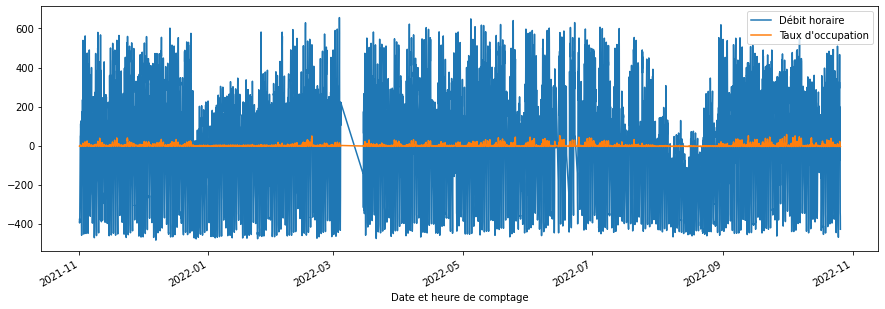

In [ ]:
# We remove the trend

y_detrended = y_train - y_trend_fit
y_detrended.plot(figsize=(15,5))

In [ ]:
y_detrended_test = y_test - y_trend_pred


### Seasonality

#### Testing different fourier order values

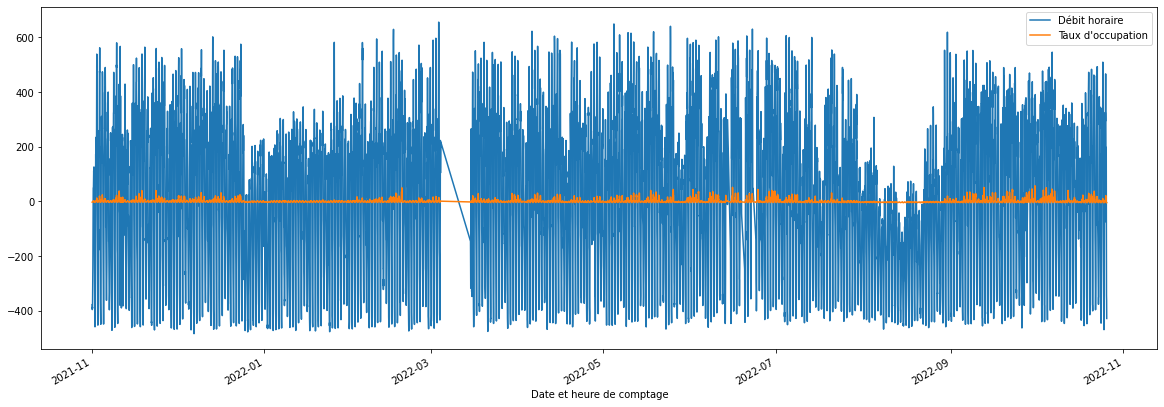

In [ ]:
y_detrended.plot(figsize=(20,7))

In [ ]:
def testing_best_fourier_order(freq_type, order):

  fourier = CalendarFourier(freq=freq_type, order=order)  # 10 sin/cos pairs for "W"eekly seasonality

  dp_season = DeterministicProcess(
      index=y.index,
      constant=True,               # dummy feature for bias (y-intercept)
      order=1,                     # trend (order 1 means linear)
      seasonal=False,               # weekly seasonality (indicators)
      additional_terms=[fourier],  # annual seasonality (fourier)
      drop=True,                   # drop terms to avoid collinearity
  )

  X_season = dp_season.in_sample() 

  X_train_season,X_test_season,y_train,y_test = timeseries_train_test_split(X_season, y, test_size=0.1)

  linear_model_season = LinearRegression(fit_intercept=False)
  linear_model_season.fit(X_train_season,y_detrended)

  y_season_fit = pd.DataFrame(
      linear_model_season.predict(X_train_season),
      index=y_train.index,
      columns=y_train.columns,
  )

  y_season_pred = pd.DataFrame(
      linear_model_season.predict(X_test_season),
      index=y_test.index,
      columns=y_test.columns,
  )
  print(f"RMSE on test set is for a Fourier order of {order} is: ", rmse(y_detrended_test,y_season_pred))
  print(f"RMSE on train set is for a Fourier order of {order} is: ", rmse(y_detrended,y_season_fit))

In [ ]:
for i in range(1,30):
  testing_best_fourier_order(freq_type="W",order=i)

RMSE on test set is for a Fourier order of 1 is:  167.50296288979914
RMSE on train set is for a Fourier order of 1 is:  198.04750323251636
RMSE on test set is for a Fourier order of 2 is:  168.6718962726252
RMSE on train set is for a Fourier order of 2 is:  197.5846957989561
RMSE on test set is for a Fourier order of 3 is:  168.77192023329297
RMSE on train set is for a Fourier order of 3 is:  197.485068524139
RMSE on test set is for a Fourier order of 4 is:  168.73991159814344
RMSE on train set is for a Fourier order of 4 is:  197.40707502471992
RMSE on test set is for a Fourier order of 5 is:  169.17652323273433
RMSE on train set is for a Fourier order of 5 is:  196.91791537463988
RMSE on test set is for a Fourier order of 6 is:  170.03240549361308
RMSE on train set is for a Fourier order of 6 is:  195.61953495452286
RMSE on test set is for a Fourier order of 7 is:  198.67713980778572
RMSE on train set is for a Fourier order of 7 is:  100.30450790492759
RMSE on test set is for a Fouri

Let's take 22

#### Choosing best value from "grid search"

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


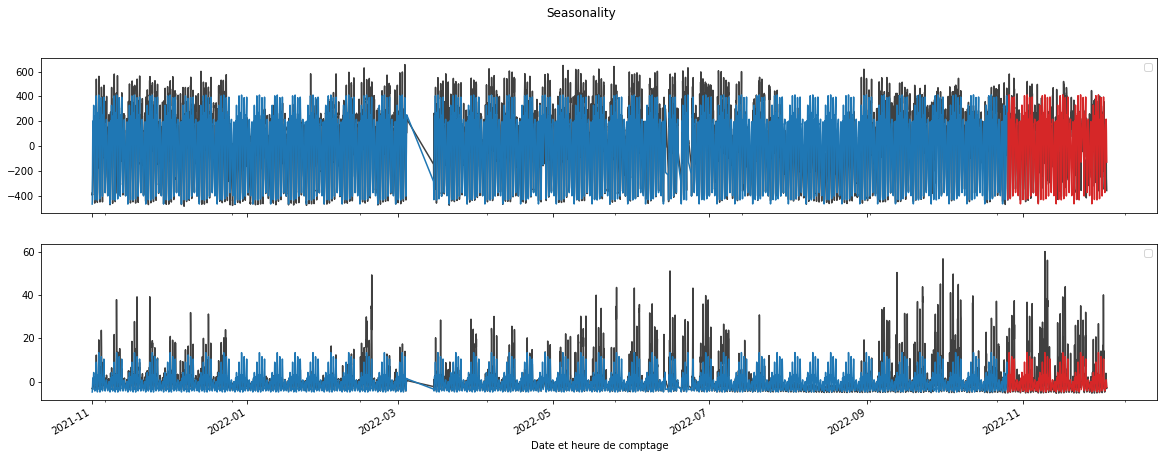

In [ ]:

# Let's now look at seasonality

fourier = CalendarFourier(freq="W", order=22)  

dp_season = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season = dp_season.in_sample() 

X_train_season,X_test_season,y_train,y_test = timeseries_train_test_split(X_season, y, test_size=0.1)

linear_model_season = LinearRegression(fit_intercept=False)
linear_model_season.fit(X_train_season,y_detrended)

y_season_fit = pd.DataFrame(
    linear_model_season.predict(X_train_season),
    index=y_train.index,
    columns=y_train.columns,
)

y_season_pred = pd.DataFrame(
    linear_model_season.predict(X_test_season),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_detrended.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_detrended_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_season_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_season_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Seasonality")

#### De-seasoned result

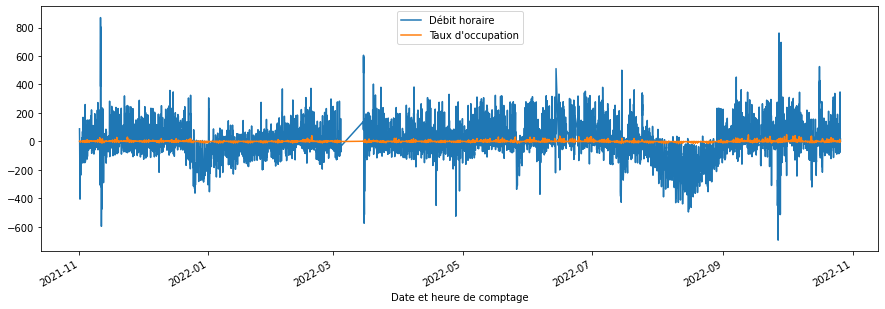

In [ ]:
y_deseasoned = y_detrended - y_season_fit
y_deseasoned.plot(figsize=(15,5))

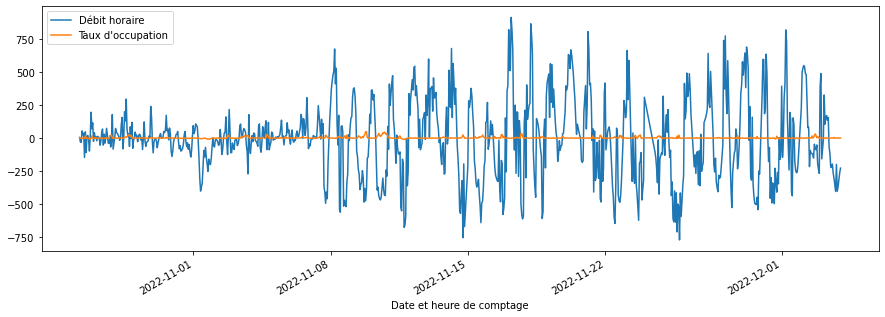

In [ ]:
y_deseasoned_test.plot(figsize=(15,5))

In [ ]:
y_deseasoned_test = y_detrended_test - y_season_pred


### Cycles

In [ ]:
y_deseasoned_total = pd.concat([y_deseasoned,y_deseasoned_test])
y_deseasoned_total

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00            88.637395           1.624838
2021-11-01 05:00:00            47.669462           1.311024
2021-11-01 06:00:00           -25.930077           0.420408
2021-11-01 07:00:00          -164.235048          -0.857642
2021-11-01 08:00:00          -270.066541          -2.241428
...                                  ...                ...
2022-12-03 20:00:00          -403.352652           0.918227
2022-12-03 21:00:00          -369.659123          -0.298615
2022-12-03 22:00:00          -316.179157          -1.550464
2022-12-03 23:00:00          -263.582612          -1.061047
2022-12-04 00:00:00          -228.788467          -0.283289

[9198 rows x 2 columns]

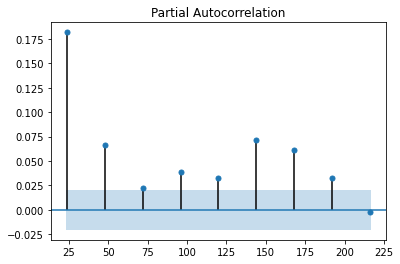

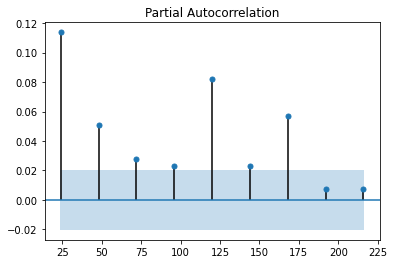

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_pacf(y_deseasoned_total["Débit horaire"],lags=[24*i for i in range(1,10)])
_ = plot_pacf(y_deseasoned_total["Taux d'occupation"],lags=[24*i for i in range(1,10)])

#### Choosing best lag features for debit

In [ ]:
def choose_best_lag(lag):
  X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag)],axis=1)
  X_lag_debit  = X_lag_debit.fillna(0.0)

  y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

  linear_model_cycle = LinearRegression(fit_intercept=False)

  X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

  linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

  y_cycle_debit_fit = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_debit_train),
      index = y_cycle_debit_train.index,
      columns = ["Débit horaire"],
  )

  y_cycle_debit_pred = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_debit_test),
      index = y_cycle_debit_test.index,
      columns = ["Débit horaire"],
  )

  print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test,y_cycle_debit_pred))
  print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

In [ ]:
for lag in range(5,14):
  choose_best_lag(lag)

RMSE on test set is for a lag of 5 is:  285.4380765046031
RMSE on train set is for a lag of 5 is:  107.1655810099155
RMSE on test set is for a lag of 6 is:  283.38727212615606
RMSE on train set is for a lag of 6 is:  106.46174069014518
RMSE on test set is for a lag of 7 is:  288.98350011543783
RMSE on train set is for a lag of 7 is:  105.78772372421582
RMSE on test set is for a lag of 8 is:  291.94680456445343
RMSE on train set is for a lag of 8 is:  108.32715491401355
RMSE on test set is for a lag of 9 is:  295.09782483551555
RMSE on train set is for a lag of 9 is:  110.12791691766283
RMSE on test set is for a lag of 10 is:  299.58298933178895
RMSE on train set is for a lag of 10 is:  111.04339043892284
RMSE on test set is for a lag of 11 is:  299.92306737551894
RMSE on train set is for a lag of 11 is:  111.0877820126254
RMSE on test set is for a lag of 12 is:  300.88903917337007
RMSE on train set is for a lag of 12 is:  112.02946403376689
RMSE on test set is for a lag of 13 is:  300.

In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(8,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  297.3387646993693
RMSE on train set is for a lag of 13 is:  106.75382625359069


In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  286.23756610286705
RMSE on train set is for a lag of 13 is:  101.12159783775012


In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(5,8)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  284.0635582859289
RMSE on train set is for a lag of 13 is:  101.86180606287236


In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(7,9)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_debit_test, y_cycle_debit_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_debit_train,y_cycle_debit_fit))

RMSE on test set is for a lag of 13 is:  290.5127761700431
RMSE on train set is for a lag of 13 is:  104.38189733943679


#### Applying best lag value for debit

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


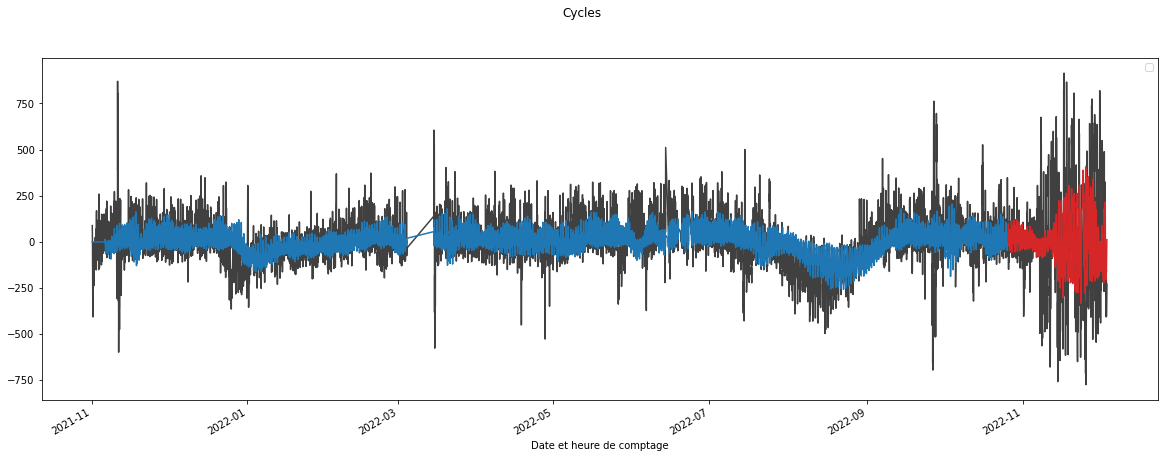

In [ ]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.1) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

axs = y_cycle_debit_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_debit_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


#### Choosing best lag features for taux

In [ ]:
def choose_best_lag(lag):
  X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag)],axis=1)
  X_lag_taux  = X_lag_taux.fillna(0.0)

  y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

  linear_model_cycle = LinearRegression(fit_intercept=False)

  X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

  linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

  y_cycle_taux_fit = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_taux_train),
      index = y_cycle_taux_train.index,
      columns = ["Taux d'occupation"],
  )

  y_cycle_taux_pred = pd.DataFrame(
      data = linear_model_cycle.predict(X_lag_taux_test),
      index = y_cycle_taux_test.index,
      columns = ["Taux d'occupation"],
  )
  print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
  print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

In [ ]:
for i in range(5,14):
  choose_best_lag(i)

RMSE on test set is for a lag of 5 is:  6.790662412089028
RMSE on train set is for a lag of 5 is:  4.3747749187472955
RMSE on test set is for a lag of 6 is:  6.581270786814087
RMSE on train set is for a lag of 6 is:  4.347421880596096
RMSE on test set is for a lag of 7 is:  6.50981378932277
RMSE on train set is for a lag of 7 is:  4.30355780418583
RMSE on test set is for a lag of 8 is:  6.875389671468239
RMSE on train set is for a lag of 8 is:  4.368652751452733
RMSE on test set is for a lag of 9 is:  7.068513502114108
RMSE on train set is for a lag of 9 is:  4.421078482968416
RMSE on test set is for a lag of 10 is:  7.005282178810674
RMSE on train set is for a lag of 10 is:  4.449956741261059
RMSE on test set is for a lag of 11 is:  6.897594003279961
RMSE on train set is for a lag of 11 is:  4.444595724747877
RMSE on test set is for a lag of 12 is:  6.791116446067165
RMSE on train set is for a lag of 12 is:  4.415025454806205
RMSE on test set is for a lag of 13 is:  6.621028477422541


In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(8,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  6.933099477232652
RMSE on train set is for a lag of 13 is:  4.345741203195078


In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  6.360792222590432
RMSE on train set is for a lag of 13 is:  4.190288015548078


In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,8)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  6.29853616796677
RMSE on train set is for a lag of 13 is:  4.220221835615931


In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,9)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)
print(f"RMSE on test set is for a lag of {lag} is: ", rmse(y_cycle_taux_test,y_cycle_taux_pred))
print(f"RMSE on train set is for a lag of {lag} is: ", rmse(y_cycle_taux_train,y_cycle_taux_fit))

RMSE on test set is for a lag of 13 is:  6.318949856612083
RMSE on train set is for a lag of 13 is:  4.195176754682903


#### Applying best lag value for taux

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


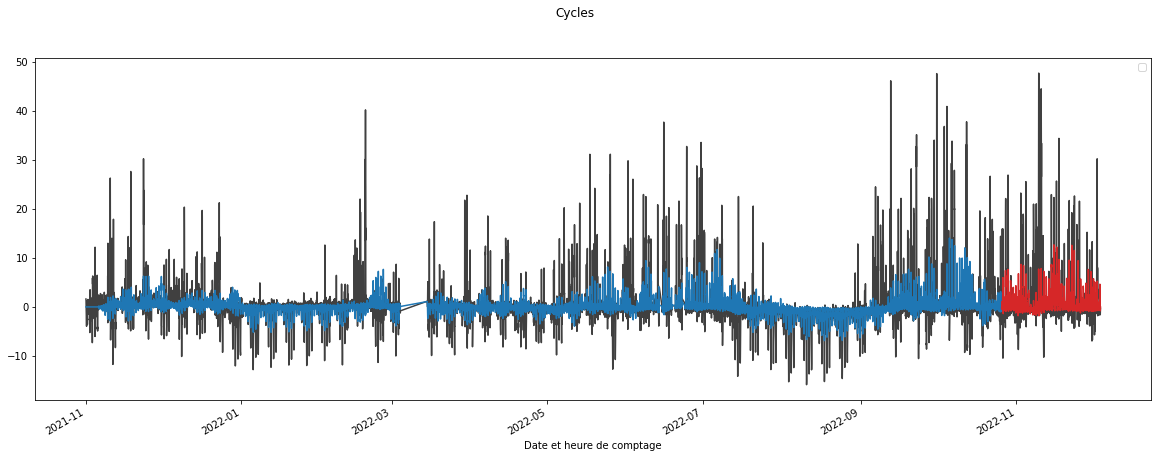

In [ ]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.1) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)

axs = y_cycle_taux_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_taux_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


In [ ]:
y_deseasoned_debit = y_deseasoned.drop(columns=["Taux d'occupation"])
y_deseasoned_taux = y_deseasoned.drop(columns=["Débit horaire"])

y_deseasoned_debit_test = y_deseasoned_test.drop(columns=["Taux d'occupation"])
y_deseasoned_taux_test = y_deseasoned_test.drop(columns=["Débit horaire"])

In [ ]:
y_residual_debit_train = y_deseasoned_debit - y_cycle_debit_fit
y_residual_debit_test = y_deseasoned_debit_test - y_cycle_debit_pred

y_residual_taux_train = y_deseasoned_taux - y_cycle_taux_fit
y_residual_taux_test = y_deseasoned_taux_test - y_cycle_taux_pred

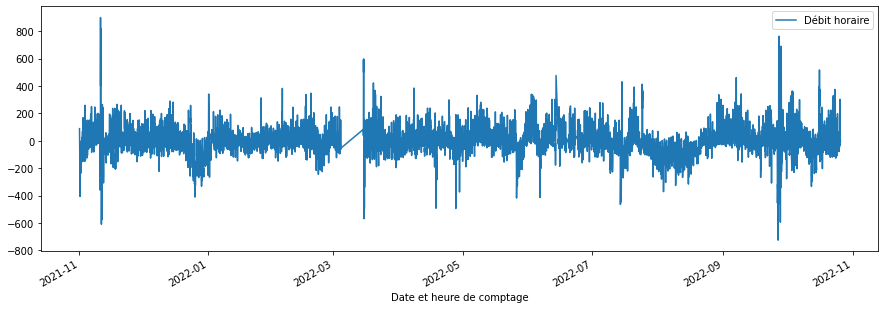

In [ ]:
y_residual_debit_train.plot(figsize=(15,5))

### Trend + season + cycles

In [ ]:
y_cycle_pred = pd.concat([y_cycle_taux_pred,y_cycle_debit_pred],axis=1)
y_cycle_pred

Taux d'occupation  Débit horaire
Date et heure de comptage                                  
2022-10-26 05:00:00                -0.237951       6.376746
2022-10-26 06:00:00                -0.140231       3.032807
2022-10-26 07:00:00                -0.324476      -0.025281
2022-10-26 08:00:00                -0.395356      34.361465
2022-10-26 09:00:00                 0.456605      98.290329
...                                      ...            ...
2022-12-03 20:00:00                 0.689064    -161.482151
2022-12-03 21:00:00                -0.403302     -86.556903
2022-12-03 22:00:00                -0.799811     -67.394410
2022-12-03 23:00:00                -0.346157     -20.711997
2022-12-04 00:00:00                 0.001154      12.384233

[920 rows x 2 columns]

In [ ]:
y_cycle_fit = pd.concat([y_cycle_taux_fit,y_cycle_debit_fit],axis=1)
y_cycle_fit

Taux d'occupation  Débit horaire
Date et heure de comptage                                  
2021-11-01 04:00:00                 0.000000       0.000000
2021-11-01 05:00:00                 0.000000       0.000000
2021-11-01 06:00:00                 0.000000       0.000000
2021-11-01 07:00:00                 0.000000       0.000000
2021-11-01 08:00:00                 0.000000       0.000000
...                                      ...            ...
2022-10-26 00:00:00                 0.327336      45.289912
2022-10-26 01:00:00                -0.257115      21.345866
2022-10-26 02:00:00                -0.822265      -7.574641
2022-10-26 03:00:00                -0.771154      10.485379
2022-10-26 04:00:00                -0.534861      15.345091

[8278 rows x 2 columns]

In [ ]:
y_pred_deterministic = y_trend_pred + y_season_pred + y_cycle_pred 
y_pred_deterministic

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2022-10-26 05:00:00            90.854018           0.570962
2022-10-26 06:00:00           161.697051           0.895142
2022-10-26 07:00:00           298.749973           2.263719
2022-10-26 08:00:00           507.526848           4.687453
2022-10-26 09:00:00           733.627555           7.966349
...                                  ...                ...
2022-12-03 20:00:00           532.716655           6.526397
2022-12-03 21:00:00           540.179143           4.630313
2022-12-03 22:00:00           472.092439           3.407873
2022-12-03 23:00:00           432.409076           3.201000
2022-12-04 00:00:00           396.941931           3.124443

[920 rows x 2 columns]

In [ ]:
y_fit_deterministic = y_trend_fit + y_season_fit + y_cycle_fit
y_fit_deterministic

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00            56.362605          -0.708728
2021-11-01 05:00:00            79.330538          -0.548804
2021-11-01 06:00:00           161.930077           0.275152
2021-11-01 07:00:00           296.235048           1.729312
2021-11-01 08:00:00           455.066541           3.481428
...                                  ...                ...
2022-10-26 00:00:00           409.694768           2.242475
2022-10-26 01:00:00           304.307991           1.929866
2022-10-26 02:00:00           196.401715           1.718210
2022-10-26 03:00:00           140.709098           1.538685
2022-10-26 04:00:00            96.558969           0.976840

[8278 rows x 2 columns]

In [ ]:
X = df_cnvtn_base
y = df_cnvtn_base

_,_,y_train,y_test = timeseries_train_test_split(X,y,test_size=0.1)

#### On test set

In [ ]:
rmse(y_test,y_pred_deterministic)

202.4504926225078

In [ ]:
rmse(y_test["Taux d'occupation"],y_pred_deterministic["Taux d'occupation"])

6.360792222590432

In [ ]:
rmse(y_test["Débit horaire"],y_pred_deterministic["Débit horaire"])

286.2375661028671

#### On train set

In [ ]:
rmse(y_train["Débit horaire"],y_fit_deterministic["Débit horaire"])

101.12159783775013

In [ ]:
rmse(y_train["Taux d'occupation"],y_fit_deterministic["Taux d'occupation"])

4.190288015548078

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


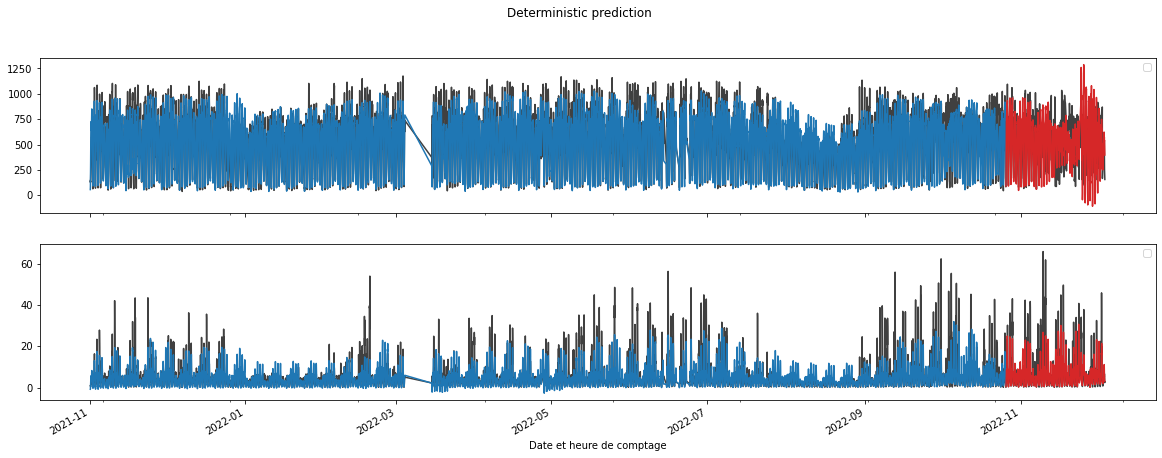

In [ ]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit_deterministic.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred_deterministic.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Deterministic prediction")


### Dealing with Residual

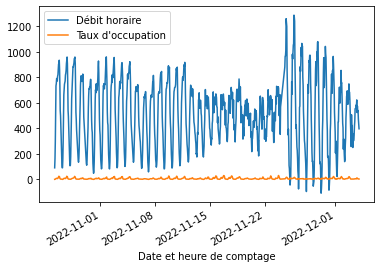

In [ ]:
y_pred_deterministic.plot()

In [ ]:
y_residual_train = y_train - y_fit_deterministic
y_residual_test = y_test - y_pred_deterministic

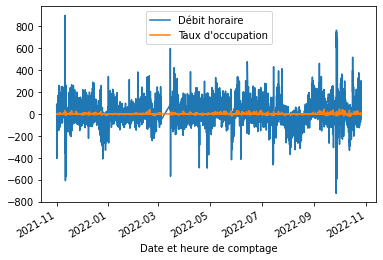

In [ ]:
y_residual_train.plot()

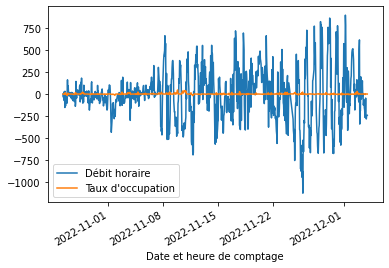

In [ ]:
y_residual_test.plot()

In [ ]:
df_cnvtn_full.columns

Index(['Libelle', 'Débit horaire', 'Taux d'occupation', 'Etat trafic',
       'Etat arc_Barré', 'Etat arc_Invalide', 'Jour férié',
       'Jour de la semaine_0', 'Jour de la semaine_1', 'Jour de la semaine_2',
       'Jour de la semaine_3', 'Jour de la semaine_4', 'Jour de la semaine_5',
       'Jour de la semaine_6', 'maxtempC', 'mintempC', 'avgtempC',
       'totalSnow_cm', 'uvIndex', 'tempC', 'windspeedKmph', 'winddirDegree',
       'weatherCode', 'precipMM', 'humidity', 'visibility', 'pressure',
       'cloudcover', 'HeatIndexC', 'DewPointC', 'WindChillC', 'WindGustKmph',
       'FeelsLikeC', 'is_day', 'paris_repsire', 'perturbation_travaux',
       'Prix du carburant'],
      dtype='object')

In [ ]:
unused_columns_for_debit = [
    "Libelle",
    "Débit horaire",
    "Taux d'occupation",
    "Etat trafic",
    "Etat arc_Barré",
    "Etat arc_Invalide",
    "Prix du carburant",
    'Jour de la semaine_0', 
    'Jour de la semaine_1', 
    'Jour de la semaine_2',
    'Jour de la semaine_3', 
    'Jour de la semaine_4', 
    'Jour de la semaine_5',
    'Jour de la semaine_6',
    ]

unused_weather = [
    "maxtempC",
    "mintempC",
    "avgtempC",
    "visibility",
    "pressure",
    "HeatIndexC",
    "DewPointC",
    "WindChillC",
    "WindGustKmph",   
    "FeelsLikeC",
    "weatherCode",
    "winddirDegree"
]

In [ ]:
X_external = df_cnvtn_full.drop(columns=unused_columns_for_debit+unused_weather)
X_external["Jour férié"]=X_external["Jour férié"].astype(bool)
X_external["perturbation_travaux"]=X_external["perturbation_travaux"].astype(bool)

X_external

Jour férié  totalSnow_cm  uvIndex  tempC  \
Date et heure de comptage                                             
2021-11-01 04:00:00              True           0.0        1     10   
2021-11-01 05:00:00              True           0.0        1     10   
2021-11-01 06:00:00              True           0.0        4     11   
2021-11-01 07:00:00              True           0.0        4     10   
2021-11-01 08:00:00              True           0.0        4     10   
...                               ...           ...      ...    ...   
2022-12-03 20:00:00             False           0.0        1      3   
2022-12-03 21:00:00             False           0.0        1      3   
2022-12-03 22:00:00             False           0.0        1      3   
2022-12-03 23:00:00             False           0.0        1      2   
2022-12-04 00:00:00             False           0.0        1      2   

                           windspeedKmph  precipMM  humidity  cloudcover  \
Date et heure de comptage                                                  
2021-11-01 04:00:00                   18       0.0        79          29   
2021-11-01 05:00:00                   19       0.0        78          36   
2021-11-01 06:00:00                   19       0.0        76          43   
2021-11-01 07:00:00                   18       0.0        76          32   
2021-11-01 08:00:00                   17       0.0        76          21   
...                                  ...       ...       ...         ...   
2022-12-03 20:00:00                   12       0.0        78         100   
2022-12-03 21:00:00                   12       0.0        78         100   
2022-12-03 22:00:00                   11       0.0        79          71   
2022-12-03 23:00:00                   10       0.0        80          42   
2022-12-04 00:00:00                    9       0.0        81          12   

                           is_day  paris_repsire  perturbation_travaux  
Date et heure de comptage                                               
2021-11-01 04:00:00         False          False                 False  
2021-11-01 05:00:00         False          False                 False  
2021-11-01 06:00:00         False          False                 False  
2021-11-01 07:00:00         False          False                 False  
2021-11-01 08:00:00          True          False                 False  
...                           ...            ...                   ...  
2022-12-03 20:00:00         False          False                  True  
2022-12-03 21:00:00         False          False                  True  
2022-12-03 22:00:00         False          False                  True  
2022-12-03 23:00:00         False          False                  True  
2022-12-04 00:00:00         False          False                  True  

[9198 rows x 11 columns]

In [ ]:
X_external_train,X_external_test,_,_ = timeseries_train_test_split(X_external,y,test_size=0.1)

In [ ]:
y_residual_train_debit = y_residual_train.drop(columns=["Taux d'occupation"])
y_residual_test_debit = y_residual_test.drop(columns=["Taux d'occupation"])

In [ ]:
y_residual_train_taux = y_residual_train.drop(columns=["Débit horaire"])
y_residual_test_taux = y_residual_test.drop(columns=["Débit horaire"])

#### Initial test: no standardization, no hyperparameter tuning

In [ ]:
# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_external_train, y_residual_train_debit)

[14:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
# Add the predicted residuals onto the predicted deterministic 
y_fit_boosted = xgb.predict(X_external_train) + y_fit_deterministic["Débit horaire"]
y_pred_boosted = xgb.predict(X_external_test) + y_pred_deterministic["Débit horaire"]

In [ ]:
rmse(y_test["Débit horaire"],y_pred_boosted)

266.893157007374

#### Standardization

In [ ]:
X_external_train.columns

Index(['Jour férié', 'totalSnow_cm', 'uvIndex', 'tempC', 'windspeedKmph',
       'precipMM', 'humidity', 'cloudcover', 'is_day', 'paris_repsire',
       'perturbation_travaux'],
      dtype='object')

In [ ]:
numerical_features = [
    "totalSnow_cm",
    "uvIndex",	
    "tempC",	
    "windspeedKmph",	
    "precipMM",	
    "humidity",
    "cloudcover"
]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(X_external_train[numerical_features])
X_external_train[numerical_features] = scaler.transform(X_external_train[numerical_features])
X_external_test[numerical_features] = scaler.transform(X_external_test[numerical_features])

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_external_train, y_residual_train_debit)

[11:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
# Add the predicted residuals onto the predicted deterministic 
y_fit_boosted = xgb.predict(X_external_train) + y_fit_deterministic["Débit horaire"]
y_pred_boosted = xgb.predict(X_external_test) + y_pred_deterministic["Débit horaire"]

In [ ]:
rmse(y_test["Débit horaire"],y_pred_boosted)

319.47224980544337

In [ ]:
rmse(y_train["Débit horaire"],y_fit_boosted)

90.80790557093343

#### Initial gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid = {
    'max_depth': [6, 10, 15, 20],
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.3, 0.01, 0.05]
}

grid_search = GridSearchCV(XGBRegressor(),param_grid=pgrid,cv=5,verbose=11)
grid_search.fit(X_external_train, y_residual_train_debit)



Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START learning_rate=0.3, max_depth=6, n_estimators=100...........
[23:17:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5; 1/36] END learning_rate=0.3, max_depth=6, n_estimators=100;, score=-0.233 total time=   0.6s
[CV 2/5; 1/36] START learning_rate=0.3, max_depth=6, n_estimators=100...........
[23:17:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5; 1/36] END learning_rate=0.3, max_depth=6, n_estimators=100;, score=-0.414 total time=   0.7s
[CV 3/5; 1/36] START learning_rate=0.3, max_depth=6, n_estimators=100...........
[23:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5; 1/36] END learning_rate=0.3, max_depth=6, n_estimators=100;, score=-0.232 total time=   0.9s
[CV 4/5;

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.3, 0.01, 0.05],
                         'max_depth': [6, 10, 15, 20],
                         'n_estimators': [100, 200, 500]},
             verbose=11)

In [ ]:
print('n_estimators = ' + str(grid_search.best_estimator_.n_estimators))
print('max_depth = ' + str(grid_search.best_estimator_.max_depth))
print('learning_rate = ' + str(grid_search.best_estimator_.learning_rate))

n_estimators = 100
max_depth = 6
learning_rate = 0.01


In [ ]:
# Train XGBoost on the residuals
xgb = XGBRegressor(n_estimators=100,max_depth=6,learning_rate=0.01)
xgb.fit(X_external_train, y_residual_train_debit)

[23:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.01, max_depth=6)

In [ ]:
# Add the predicted residuals onto the predicted deterministic 
y_fit_boosted = xgb.predict(X_external_train) + y_fit_deterministic["Débit horaire"]
y_pred_boosted = xgb.predict(X_external_test) + y_pred_deterministic["Débit horaire"]

In [ ]:
rmse(y_test["Débit horaire"],y_pred_boosted)

249.94460296437848

In [ ]:
rmse(y_train["Débit horaire"],y_fit_boosted)

215.86097566751505

Let's just test with normal XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators=100,max_depth=6,learning_rate=0.01)
xgb.fit(X_external_train, y_train["Débit horaire"])
y_fit_xgb = xgb.predict(X_external_train)
y_pred_xgb = xgb.predict(X_external_test)
print("RMSE for test set is:",rmse(y_test["Débit horaire"],y_pred_xgb))
print("RMSE for train set is:",rmse(y_train["Débit horaire"],y_fit_xgb))

[23:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for test set is: 484.3457437248998
RMSE for train set is: 448.7701102121992


LOL

#### Subset selection

In [ ]:
def processSubset(feature_set):
    xgb = XGBRegressor()
    xgb.fit(X_external_train[list(feature_set)], y_residual_train_debit)
    y_fit_boosted = xgb.predict(X_external_train[list(feature_set)]) + y_fit_deterministic["Débit horaire"]
    y_pred_boosted = xgb.predict(X_external_test[list(feature_set)]) + y_pred_deterministic["Débit horaire"]
    score = rmse(y_test["Débit horaire"],y_pred_boosted)
    return {"model":list(feature_set), "RMSE":score}

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def getBest(k):
    
    tic = time.time()
    
    results = []

    
    for combo in itertools.combinations(X_external_train.columns, k):
        processed = processSubset(combo)
        results.append(processed)
  
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RMSE'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_best = pd.DataFrame(columns=["model", "RMSE"])

tic = time.time()
for i in tqdm(range(1,12)):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

  0%|          | 0/11 [00:00<?, ?it/s]

[00:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

  9%|▉         | 1/11 [00:02<00:21,  2.18s/it]

[00:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Processed 11 models on 1 predictors in 2.174980401992798 seconds.
[00:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:03] WARNING: /workspace/src/objective/

 18%|█▊        | 2/11 [00:15<01:19,  8.79s/it]

Processed 55 models on 2 predictors in 13.416926145553589 seconds.
[00:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:17] WARNING: /workspace/src/objective

 27%|██▋       | 3/11 [01:02<03:30, 26.36s/it]

Processed 165 models on 3 predictors in 47.265185832977295 seconds.
[00:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:04] WARNING: /workspace/src/objectiv

 36%|███▋      | 4/11 [02:42<06:27, 55.36s/it]

Processed 330 models on 4 predictors in 99.80928444862366 seconds.
[00:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:44] WARNING: /workspace/src/objective

 45%|████▌     | 5/11 [05:13<08:57, 89.64s/it]

Processed 462 models on 5 predictors in 150.42183136940002 seconds.
[00:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:45:15] WARNING: /workspace/src/objectiv

 55%|█████▍    | 6/11 [07:53<09:28, 113.70s/it]

Processed 462 models on 6 predictors in 160.37843775749207 seconds.
[00:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:55] WARNING: /workspace/src/objectiv

 64%|██████▎   | 7/11 [09:55<07:45, 116.49s/it]

Processed 330 models on 7 predictors in 122.22706484794617 seconds.
[00:49:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:58] WARNING: /workspace/src/objectiv

 73%|███████▎  | 8/11 [10:59<04:58, 99.62s/it] 

Processed 165 models on 8 predictors in 63.482178688049316 seconds.
[00:50:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:01] WARNING: /workspace/src/objectiv

 82%|████████▏ | 9/11 [11:23<02:31, 75.98s/it]

Processed 55 models on 9 predictors in 24.004196405410767 seconds.
[00:51:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:25] WARNING: /workspace/src/objective

 91%|█████████ | 10/11 [11:27<00:53, 53.98s/it]

Processed 11 models on 10 predictors in 4.706707715988159 seconds.
[00:51:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 11/11 [11:28<00:00, 62.58s/it]

Processed 1 models on 11 predictors in 0.4432051181793213 seconds.
Total elapsed time: 688.4299051761627 seconds.


In [ ]:
models_best

model        RMSE
1                                        [cloudcover]  220.746318
2                            [Jour férié, cloudcover]  220.552194
3              [Jour férié, totalSnow_cm, cloudcover]  220.555921
4   [Jour férié, totalSnow_cm, cloudcover, paris_r...  220.481675
5   [Jour férié, totalSnow_cm, precipMM, cloudcove...  220.641417
6   [Jour férié, totalSnow_cm, uvIndex, precipMM, ...  220.703603
7   [Jour férié, totalSnow_cm, uvIndex, precipMM, ...  220.999819
8   [Jour férié, totalSnow_cm, uvIndex, tempC, pre...  221.564677
9   [Jour férié, totalSnow_cm, uvIndex, tempC, pre...  222.319550
10  [Jour férié, totalSnow_cm, uvIndex, tempC, pre...  223.254641
11  [Jour férié, totalSnow_cm, uvIndex, tempC, win...  224.795461

In [ ]:
models_best.iloc[4].model

['Jour férié', 'totalSnow_cm', 'precipMM', 'cloudcover', 'paris_repsire']

In [ ]:
best_features = ['Jour férié', 'totalSnow_cm', 'precipMM', 'cloudcover', 'paris_repsire']


#### Grid search with best features

In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid = {
    'max_depth': [1, 2, 4, 6],
    'n_estimators': [30, 50, 75, 100, 125],
    'learning_rate': [0.01]
}

grid_search = GridSearchCV(XGBRegressor(),param_grid=pgrid,cv=5,verbose=11)
grid_search.fit(X_external_train[best_features], y_residual_train_debit)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START learning_rate=0.01, max_depth=1, n_estimators=30...........
[00:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5; 1/20] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-0.012 total time=   0.1s
[CV 2/5; 1/20] START learning_rate=0.01, max_depth=1, n_estimators=30...........
[00:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5; 1/20] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-0.053 total time=   0.1s
[CV 3/5; 1/20] START learning_rate=0.01, max_depth=1, n_estimators=30...........
[00:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5; 1/20] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-0.014 total time=   0.1s
[CV 4/5;

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.01], 'max_depth': [1, 2, 4, 6],
                         'n_estimators': [30, 50, 75, 100, 125]},
             verbose=11)

In [ ]:
print('n_estimators = ' + str(grid_search.best_estimator_.n_estimators))
print('max_depth = ' + str(grid_search.best_estimator_.max_depth))
print('learning_rate = ' + str(grid_search.best_estimator_.learning_rate))

n_estimators = 30
max_depth = 1
learning_rate = 0.01


In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid = {
    'max_depth': [1],
    'n_estimators': [10, 20, 25, 30, 35, 40],
    'learning_rate': [0.01]
}

grid_search = GridSearchCV(XGBRegressor(),param_grid=pgrid,cv=5,verbose=11)
grid_search.fit(X_external_train[best_features], y_residual_train_debit)
print('n_estimators = ' + str(grid_search.best_estimator_.n_estimators))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START learning_rate=0.01, max_depth=1, n_estimators=10............
[00:59:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5; 1/6] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=-0.011 total time=   0.1s
[CV 2/5; 1/6] START learning_rate=0.01, max_depth=1, n_estimators=10............
[00:59:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5; 1/6] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=-0.050 total time=   0.1s
[CV 3/5; 1/6] START learning_rate=0.01, max_depth=1, n_estimators=10............
[00:59:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5; 1/6] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=-0.013 total time=   0.0s
[CV 4/5; 1/6]

In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid = {
    'max_depth': [1],
    'n_estimators': range(1,20),
    'learning_rate': [0.01]
}

grid_search = GridSearchCV(XGBRegressor(),param_grid=pgrid,cv=5,verbose=11)
grid_search.fit(X_external_train[best_features], y_residual_train_debit)
print('n_estimators = ' + str(grid_search.best_estimator_.n_estimators))

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5; 1/19] START learning_rate=0.01, max_depth=1, n_estimators=1............
[00:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5; 1/19] END learning_rate=0.01, max_depth=1, n_estimators=1;, score=-0.011 total time=   0.0s
[CV 2/5; 1/19] START learning_rate=0.01, max_depth=1, n_estimators=1............
[00:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5; 1/19] END learning_rate=0.01, max_depth=1, n_estimators=1;, score=-0.049 total time=   0.0s
[CV 3/5; 1/19] START learning_rate=0.01, max_depth=1, n_estimators=1............
[00:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5; 1/19] END learning_rate=0.01, max_depth=1, n_estimators=1;, score=-0.012 total time=   0.0s
[CV 4/5; 1/1

In [ ]:
# Train XGBoost on the residuals
xgb = XGBRegressor(n_estimators=1,max_depth=1,learning_rate=0.01)
xgb.fit(X_external_train[best_features], y_residual_train_debit)

[01:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.01, max_depth=1, n_estimators=1)

In [ ]:
# Add the predicted residuals onto the predicted deterministic 
y_fit_boosted = xgb.predict(X_external_train[best_features]) + y_fit_deterministic["Débit horaire"]
y_pred_boosted = xgb.predict(X_external_test[best_features]) + y_pred_deterministic["Débit horaire"]

In [ ]:
rmse(y_test["Débit horaire"],y_pred_boosted)

221.09974117061557

In [ ]:
rmse(y_train["Débit horaire"],y_fit_boosted)

212.0901911882739

#### Quick testing

In [ ]:
y_residual_taux_train

Taux d'occupation
Date et heure de comptage                   
2021-11-01 04:00:00                 1.624838
2021-11-01 05:00:00                 1.311024
2021-11-01 06:00:00                 0.420408
2021-11-01 07:00:00                -0.857642
2021-11-01 08:00:00                -2.241428
...                                      ...
2022-10-26 00:00:00                 3.231975
2022-10-26 01:00:00                 0.400134
2022-10-26 02:00:00                -0.784870
2022-10-26 03:00:00                -0.595905
2022-10-26 04:00:00                -0.547950

[8278 rows x 1 columns]

In [ ]:
xgb1 = XGBRegressor()
xgb2 = XGBRegressor()


best_features = ['Jour férié', 'totalSnow_cm', 'precipMM', 'cloudcover', 'paris_repsire']

xgb1.fit(X_external_train, y_residual_taux_train)

y_fit_boosted_taux = xgb1.predict(X_external_train) + y_fit_deterministic["Taux d'occupation"]
y_pred_boosted_taux = xgb1.predict(X_external_test) + y_pred_deterministic["Taux d'occupation"]
print("RMSE for all features:", rmse(y_test["Taux d'occupation"], y_pred_boosted_taux))

xgb2.fit(X_external_train[best_features], y_residual_taux_train)

y_fit_boosted_taux = xgb2.predict(X_external_train[best_features]) + y_fit_deterministic["Taux d'occupation"]
y_pred_boosted_taux = xgb2.predict(X_external_test[best_features]) + y_pred_deterministic["Taux d'occupation"]
print("RMSE for selected features:", rmse(y_test["Taux d'occupation"], y_pred_boosted_taux))

[10:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for all features: 8.46608905470739
[10:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for selected features: 8.358789222083557


In [ ]:
xgb3 = XGBRegressor()

best_features = ['Jour férié', 'totalSnow_cm', 'precipMM', 'cloudcover', 'paris_repsire']

xgb3.fit(X_external_train[best_features], y_residual_taux_train)

y_fit_boosted_taux = xgb3.predict(X_external_train[best_features]) + y_fit_deterministic["Débit horaire"]
y_pred_boosted_taux = xgb3.predict(X_external_test[best_features]) + y_pred_deterministic["Débit horaire"]
print("RMSE for selected features:", rmse(y_test["Débit horaire"], y_pred_boosted_taux))

[11:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for selected features: 286.22939609539765


# Convention FINAL (with as freq)

In [ ]:
df_cnvtn_base = df_cnvtn.drop(columns=["Libelle","Etat trafic","Etat arc_Barré", "Etat arc_Invalide"])
df_cnvtn_base.sort_values(by="Date et heure de comptage", inplace=True)
df_cnvtn_base.set_index("Date et heure de comptage",inplace=True)
df_cnvtn_base

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00           145.000000            0.91611
2021-11-01 05:00:00           127.000000            0.76222
2021-11-01 06:00:00           136.000000            0.69556
2021-11-01 07:00:00           132.000000            0.87167
2021-11-01 08:00:00           185.000000            1.24000
...                                  ...                ...
2022-12-08 20:00:00           386.571429           14.51778
2022-12-08 21:00:00           178.000000            5.43722
2022-12-08 22:00:00           154.000000            3.24611
2022-12-08 23:00:00           130.000000            2.77889
2022-12-09 00:00:00           357.285714            2.60556

[9318 rows x 2 columns]

In [ ]:
df_cnvtn_base_freq = df_cnvtn_base.asfreq('H', method= 'ffill')
df_cnvtn_base_freq

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00           145.000000            0.91611
2021-11-01 05:00:00           127.000000            0.76222
2021-11-01 06:00:00           136.000000            0.69556
2021-11-01 07:00:00           132.000000            0.87167
2021-11-01 08:00:00           185.000000            1.24000
...                                  ...                ...
2022-12-08 20:00:00           386.571429           14.51778
2022-12-08 21:00:00           178.000000            5.43722
2022-12-08 22:00:00           154.000000            3.24611
2022-12-08 23:00:00           130.000000            2.77889
2022-12-09 00:00:00           357.285714            2.60556

[9669 rows x 2 columns]

### Trend

In [ ]:
y = df_cnvtn_base_freq.copy()

# Create trend features
dp = DeterministicProcess(
    index = y.index,
    constant=True,
    order=1,
    drop=True
)
X = dp.in_sample()

In [ ]:
start="2022-12-09 01:00:00"
end="2022-12-14 00:00:00"
test_index = pd.date_range(start=start, end=end,freq='H')

In [ ]:
# Create trend features for evaluation set
dp_eval = DeterministicProcess(
    index = test_index,
    constant=True,
    order=1,
    drop=True
)
X_eval = dp_eval.in_sample()
X_eval["trend"] = X_eval["trend"]+len(X)

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


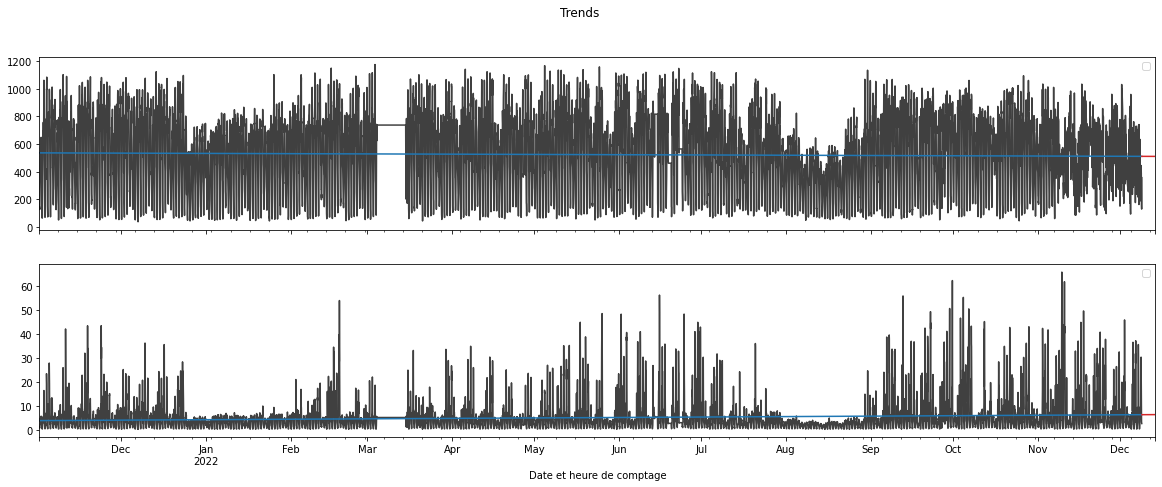

In [ ]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X,y)

y_trend_fit = pd.DataFrame(
    linear_model.predict(X),
    index=y.index,
    columns=y.columns,
)

y_trend_pred = pd.DataFrame(
    linear_model.predict(X_eval),
    index=test_index,
    columns=y.columns,
)

# Plot
axs = y.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_trend_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_trend_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


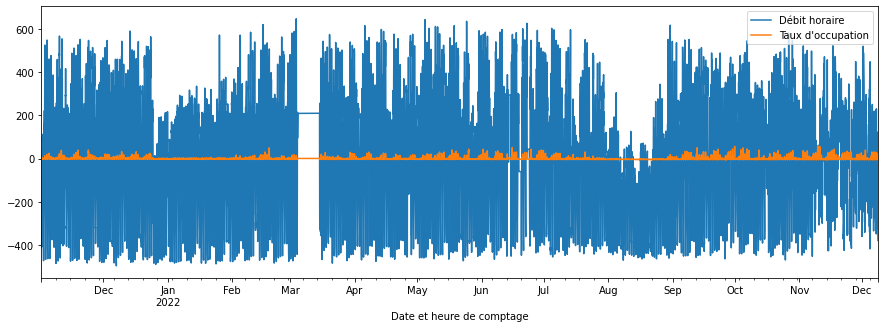

In [ ]:
# We remove the trend

y_detrended = y - y_trend_fit
y_detrended.plot(figsize=(15,5))

### Seasonality

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


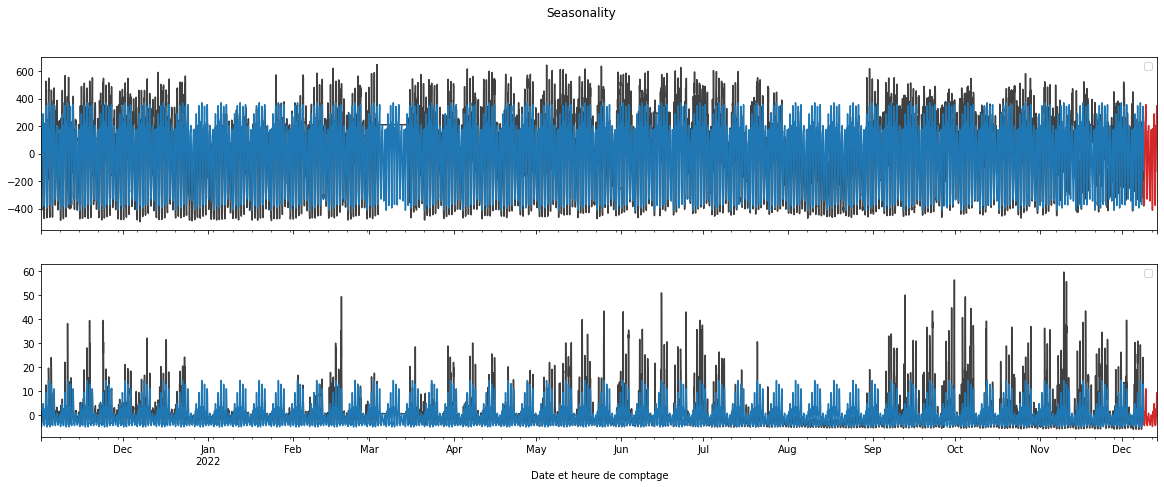

In [ ]:

# Let's now look at seasonality

fourier = CalendarFourier(freq="W", order=22)  

dp_season = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season = dp_season.in_sample() 

# evaluation features
dp_season_eval = DeterministicProcess(
    index=test_index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season_eval = dp_season_eval.in_sample() 


linear_model_season = LinearRegression(fit_intercept=False)
linear_model_season.fit(X_season,y_detrended)

y_season_fit = pd.DataFrame(
    linear_model_season.predict(X_season),
    index=y.index,
    columns=y.columns,
)

y_season_pred = pd.DataFrame(
    linear_model_season.predict(X_season_eval),
    index=test_index,
    columns=y.columns,
)

# Plot
axs = y_detrended.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_season_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_season_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Seasonality")

#### De-seasoned result

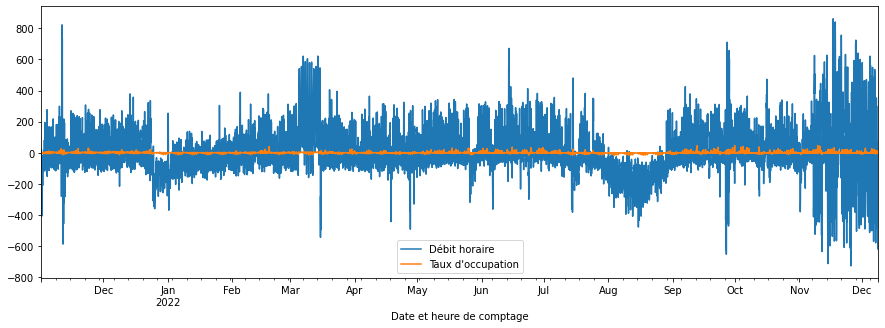

In [ ]:
y_deseasoned = y_detrended - y_season_fit
y_deseasoned.plot(figsize=(15,5))

### Cycles

#### Applying best lag value for debit

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


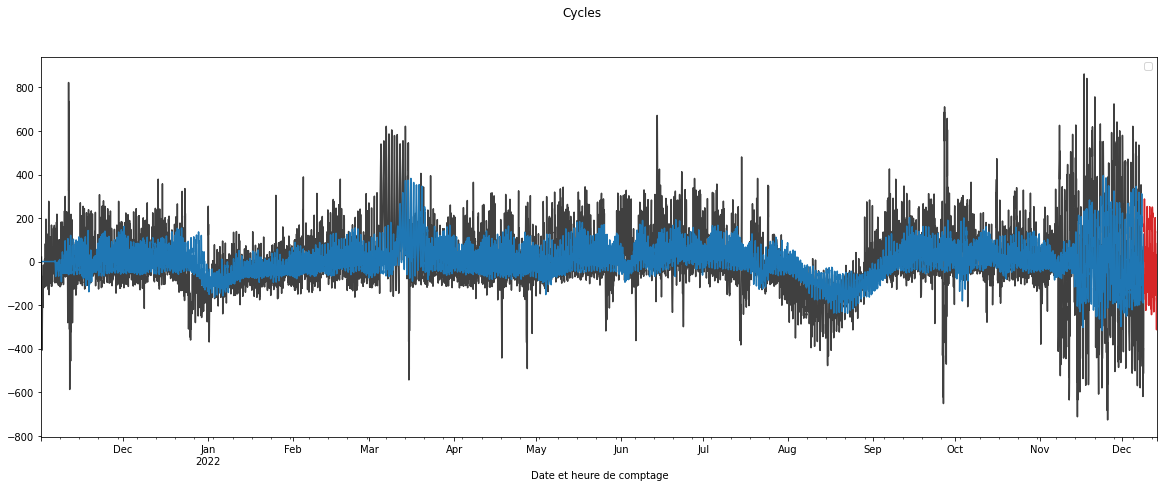

In [ ]:
X_lag_debit = pd.concat([y_deseasoned["Débit horaire"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)
X_lag_debit =  X_lag_debit.set_axis([f"Lag_{i}" for i in range(5,11)] , axis=1)

y_cycle_debit = y_deseasoned["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

linear_model_cycle.fit(X_lag_debit,y_cycle_debit)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit),
    index = y_cycle_debit.index,
    columns = ["Débit horaire"],
)

X_lag_debit_eval = pd.DataFrame(
    index = test_index,
    columns = X_lag_debit.columns
)

for i in range(5,11):
  X_lag_debit_eval[f"Lag_{i}"]=list(y_deseasoned.loc[test_index.shift(-24*i)]["Débit horaire"])

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_eval),
    index = test_index,
    columns = ["Débit horaire"],
)

axs = y_cycle_debit.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))

axs = y_cycle_debit_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


#### Applying best lag value for taux

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


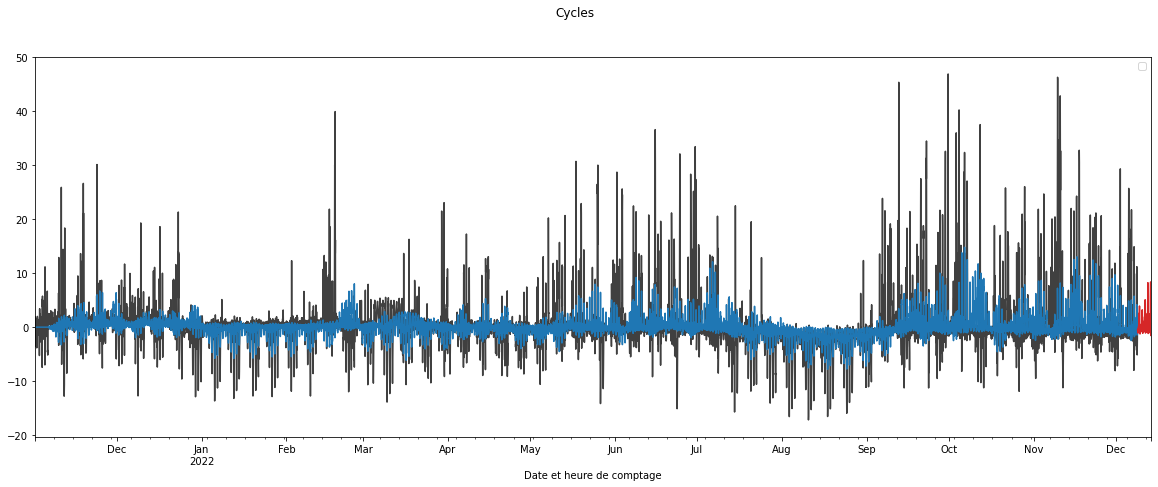

In [ ]:
X_lag_taux = pd.concat([y_deseasoned["Taux d'occupation"].shift(24*lag) for lag in range(5,11)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)
X_lag_taux =  X_lag_taux.set_axis([f"Lag_{i}" for i in range(5,11)] , axis=1)


y_cycle_taux = y_deseasoned["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)


linear_model_cycle.fit(X_lag_taux,y_cycle_taux)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux),
    index = y_cycle_taux.index,
    columns = ["Taux d'occupation"],
)

X_lag_taux_eval = pd.DataFrame(
    index = test_index,
    columns = X_lag_taux.columns
)

for i in range(5,11):
  X_lag_taux_eval[f"Lag_{i}"]=list(y_deseasoned.loc[test_index.shift(-24*i)]["Taux d'occupation"])

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_eval),
    index = test_index,
    columns = ["Taux d'occupation"],
)

axs = y_cycle_taux.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_taux_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


### Trend + season + cycles

In [ ]:
y_cycle_pred = pd.concat([y_cycle_taux_pred,y_cycle_debit_pred],axis=1)
y_cycle_pred

Taux d'occupation  Débit horaire
2022-12-09 01:00:00          -0.444857     139.466685
2022-12-09 02:00:00          -0.911547     162.727911
2022-12-09 03:00:00          -1.086519     171.650347
2022-12-09 04:00:00          -0.880091     146.571984
2022-12-09 05:00:00          -0.600627     200.143055
...                                ...            ...
2022-12-13 20:00:00           2.996731    -200.328244
2022-12-13 21:00:00          -1.564715    -249.781309
2022-12-13 22:00:00          -1.308099    -151.987108
2022-12-13 23:00:00          -0.199547      -8.136803
2022-12-14 00:00:00           0.729996      82.100678

[120 rows x 2 columns]

In [ ]:
y_cycle_fit = pd.concat([y_cycle_taux_fit,y_cycle_debit_fit],axis=1)
y_cycle_fit

Taux d'occupation  Débit horaire
Date et heure de comptage                                  
2021-11-01 04:00:00                 0.000000       0.000000
2021-11-01 05:00:00                 0.000000       0.000000
2021-11-01 06:00:00                 0.000000       0.000000
2021-11-01 07:00:00                 0.000000       0.000000
2021-11-01 08:00:00                 0.000000       0.000000
...                                      ...            ...
2022-12-08 20:00:00                -0.633029     -85.306862
2022-12-08 21:00:00                -0.968766     -50.143899
2022-12-08 22:00:00                -1.434867     -31.866741
2022-12-08 23:00:00                -0.279020      56.230719
2022-12-09 00:00:00                 0.053107     125.395868

[9669 rows x 2 columns]

In [ ]:
y_pred_deterministic = y_trend_pred + y_season_pred + y_cycle_pred 
y_pred_deterministic

Débit horaire  Taux d'occupation
2022-12-09 01:00:00     445.961319           2.181837
2022-12-09 02:00:00     395.394339           2.152893
2022-12-09 03:00:00     344.188539           1.943342
2022-12-09 04:00:00     284.286095           1.577161
2022-12-09 05:00:00     343.205356           1.262929
...                            ...                ...
2022-12-13 20:00:00     578.603647          15.921276
2022-12-13 21:00:00     426.961812           7.525398
2022-12-13 22:00:00     414.010993           4.114004
2022-12-13 23:00:00     457.853239           2.897222
2022-12-14 00:00:00     463.315359           3.160098

[120 rows x 2 columns]

In [ ]:
y_pred_deterministic.to_csv("/content/drive/MyDrive/CentraleSupelec/3A/BCG_datathon/Results/convention_preds.csv",sep=";")

In [ ]:
y_fit_deterministic = y_trend_fit + y_season_fit + y_cycle_fit
y_fit_deterministic

Débit horaire  Taux d'occupation
Date et heure de comptage                                  
2021-11-01 04:00:00           124.663514          -1.006030
2021-11-01 05:00:00           144.669705          -0.863505
2021-11-01 06:00:00           219.488528          -0.056068
2021-11-01 07:00:00           341.235329           1.392243
2021-11-01 08:00:00           484.314663           3.148310
...                                  ...                ...
2022-12-08 20:00:00           698.753958          14.568947
2022-12-08 21:00:00           642.441865           9.613430
2022-12-08 22:00:00           554.901656           4.816199
2022-12-08 23:00:00           539.259318           3.152465
2022-12-09 00:00:00           514.683508           2.470297

[9669 rows x 2 columns]

#### On train set

In [ ]:
rmse(y["Débit horaire"],y_fit_deterministic["Débit horaire"])

134.21658802108254

In [ ]:
rmse(y["Taux d'occupation"],y_fit_deterministic["Taux d'occupation"])

4.4383106680335365

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


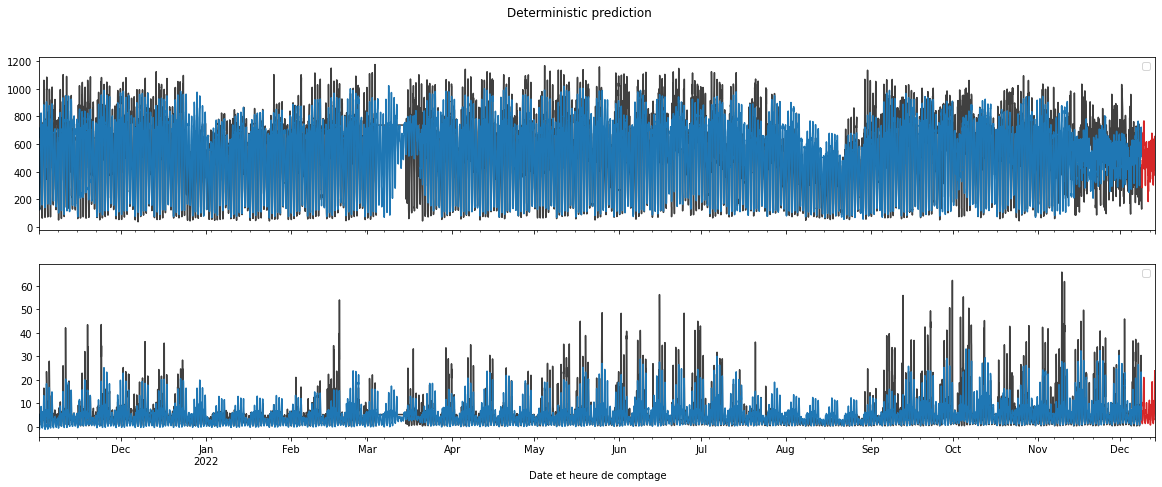

In [ ]:
axs = y.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_fit_deterministic.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred_deterministic.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Deterministic prediction")


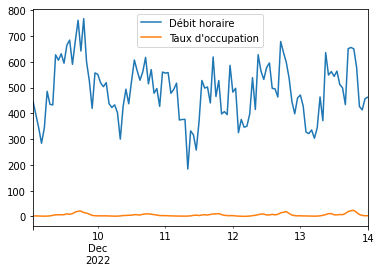

In [ ]:
y_pred_deterministic.plot()